# comparison between posteriors derived from ANPE versus MCMC

In [1]:
import os
import h5py
import numpy as np 
from scipy import stats

from sedflow import train as Train

In [2]:
from IPython.display import IFrame
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
#mpl.use('PDF')
#mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
import torch
from torch.utils.tensorboard.writer import SummaryWriter

from sbi import utils as Ut
from sbi import inference as Inference

# load SDSS spectra
These spectra lie within the training data support

In [4]:
dat_dir = '/scratch/network/chhahn/sedflow/'
sdss_A_spec = np.load(os.path.join(dat_dir, 'sdss.test.A_spec.npy'))[:100]
sdss_h_spec = np.load(os.path.join(dat_dir, 'sdss.test.h_spec.npy'))[:100]
sdss_A_ivar = np.load(os.path.join(dat_dir, 'sdss.test.A_ivar.npy'))[:100]
sdss_h_ivar = np.load(os.path.join(dat_dir, 'sdss.test.h_ivar.npy'))[:100]
sdss_zred   = np.load(os.path.join(dat_dir, 'sdss.test.zred.npy'))[:100]


sdss_data = np.concatenate([
    sdss_A_spec[:,None],
    sdss_h_spec,
    sdss_A_ivar[:,None],
    sdss_h_ivar,
    sdss_zred[:,None]], axis=1)

# load ANPE

In [6]:
arch = '500x5.2.cpu'
hatp_x_y = torch.load('/scratch/network/chhahn/sedflow/anpe/anpe.sedflow_p.%s.pt' % arch)
hatp_x_y._device = torch.device('cpu')

# sample posterior using ANPE

In [7]:
prior_sps = Train.prior_default()

In [8]:
_low = [7, 0., 0., 0., 0., 0., 1e-2, np.log10(4.5e-5), np.log10(4.5e-5), 0, 0., -2.]
_high = [12.5, 1., 1., 1., 1., 1., 13.27, np.log10(1.5e-2), np.log10(1.5e-2), 3., 3., 1.]
theta_range = [(l, h) for l, h in zip(_low, _high)]

theta_lbls = [r'$\log M_*$', r"$\beta_1$", r"$\beta_2$", r"$\beta_3$", r"$\beta_4$", r'$f_{\rm burst}$', r'$t_{\rm burst}$', r'$\log \gamma_1$', r'$\log \gamma_2$', r'$\tau_1$', r'$\tau_2$', r'$n_{\rm dust}$']

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

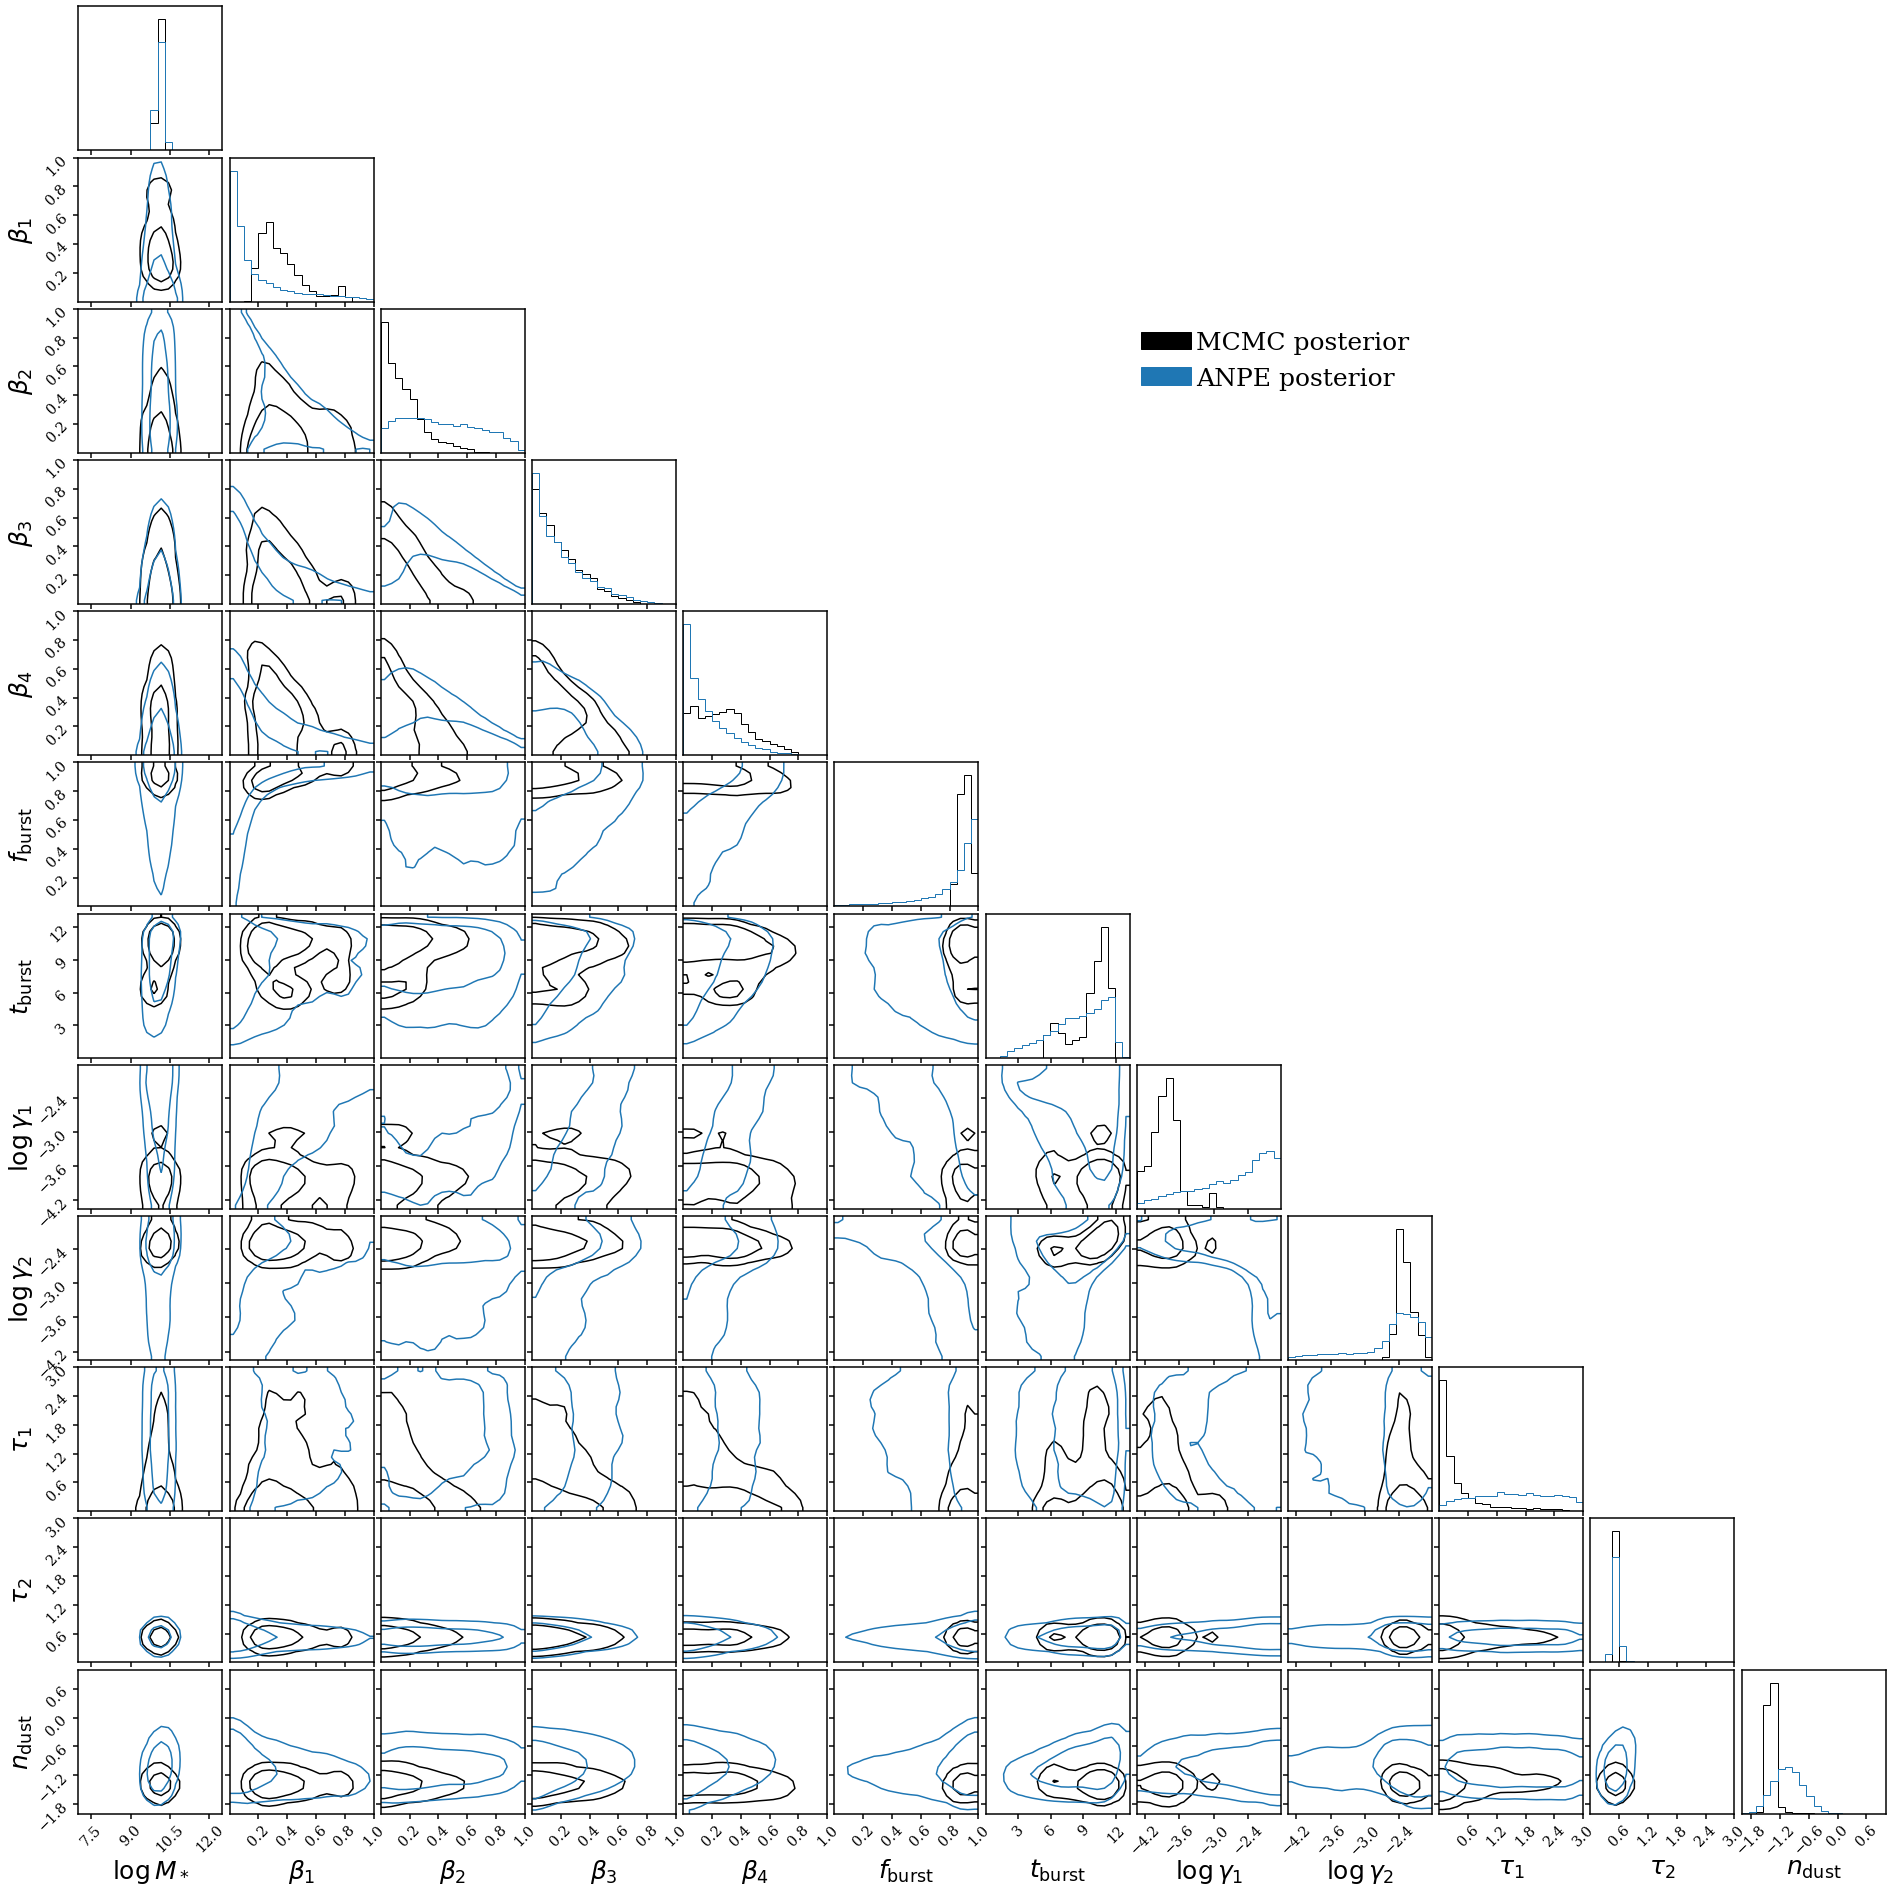

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

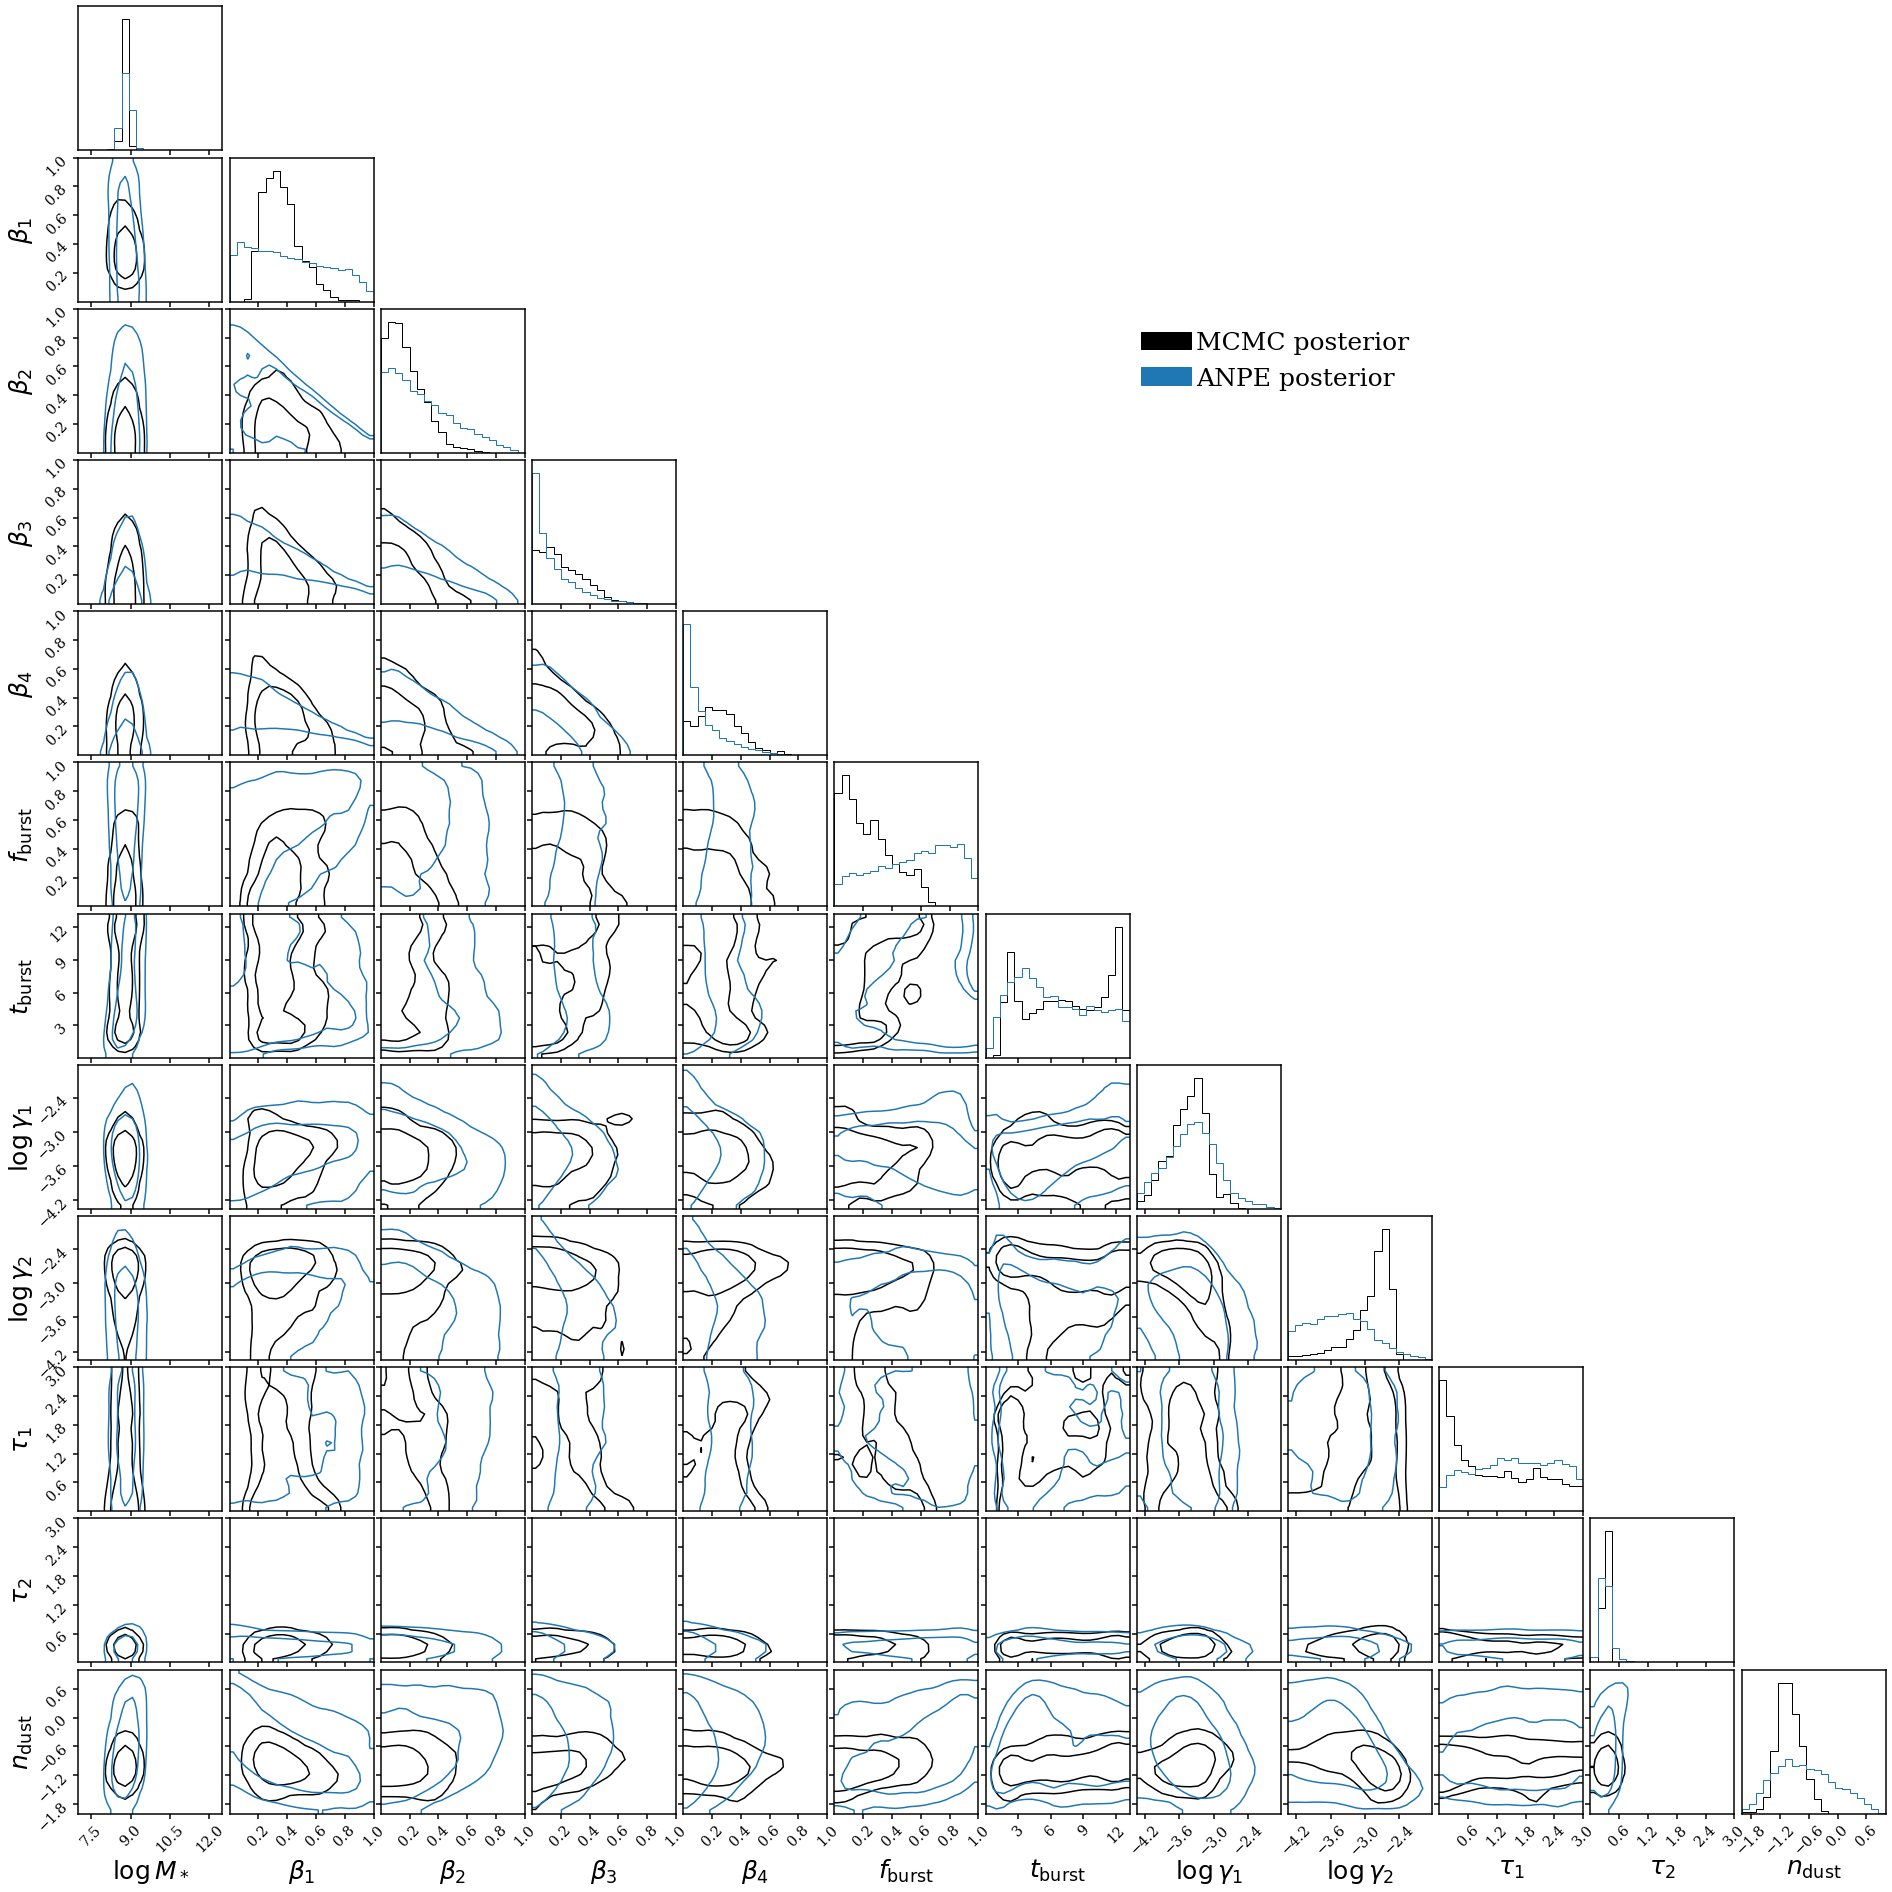

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

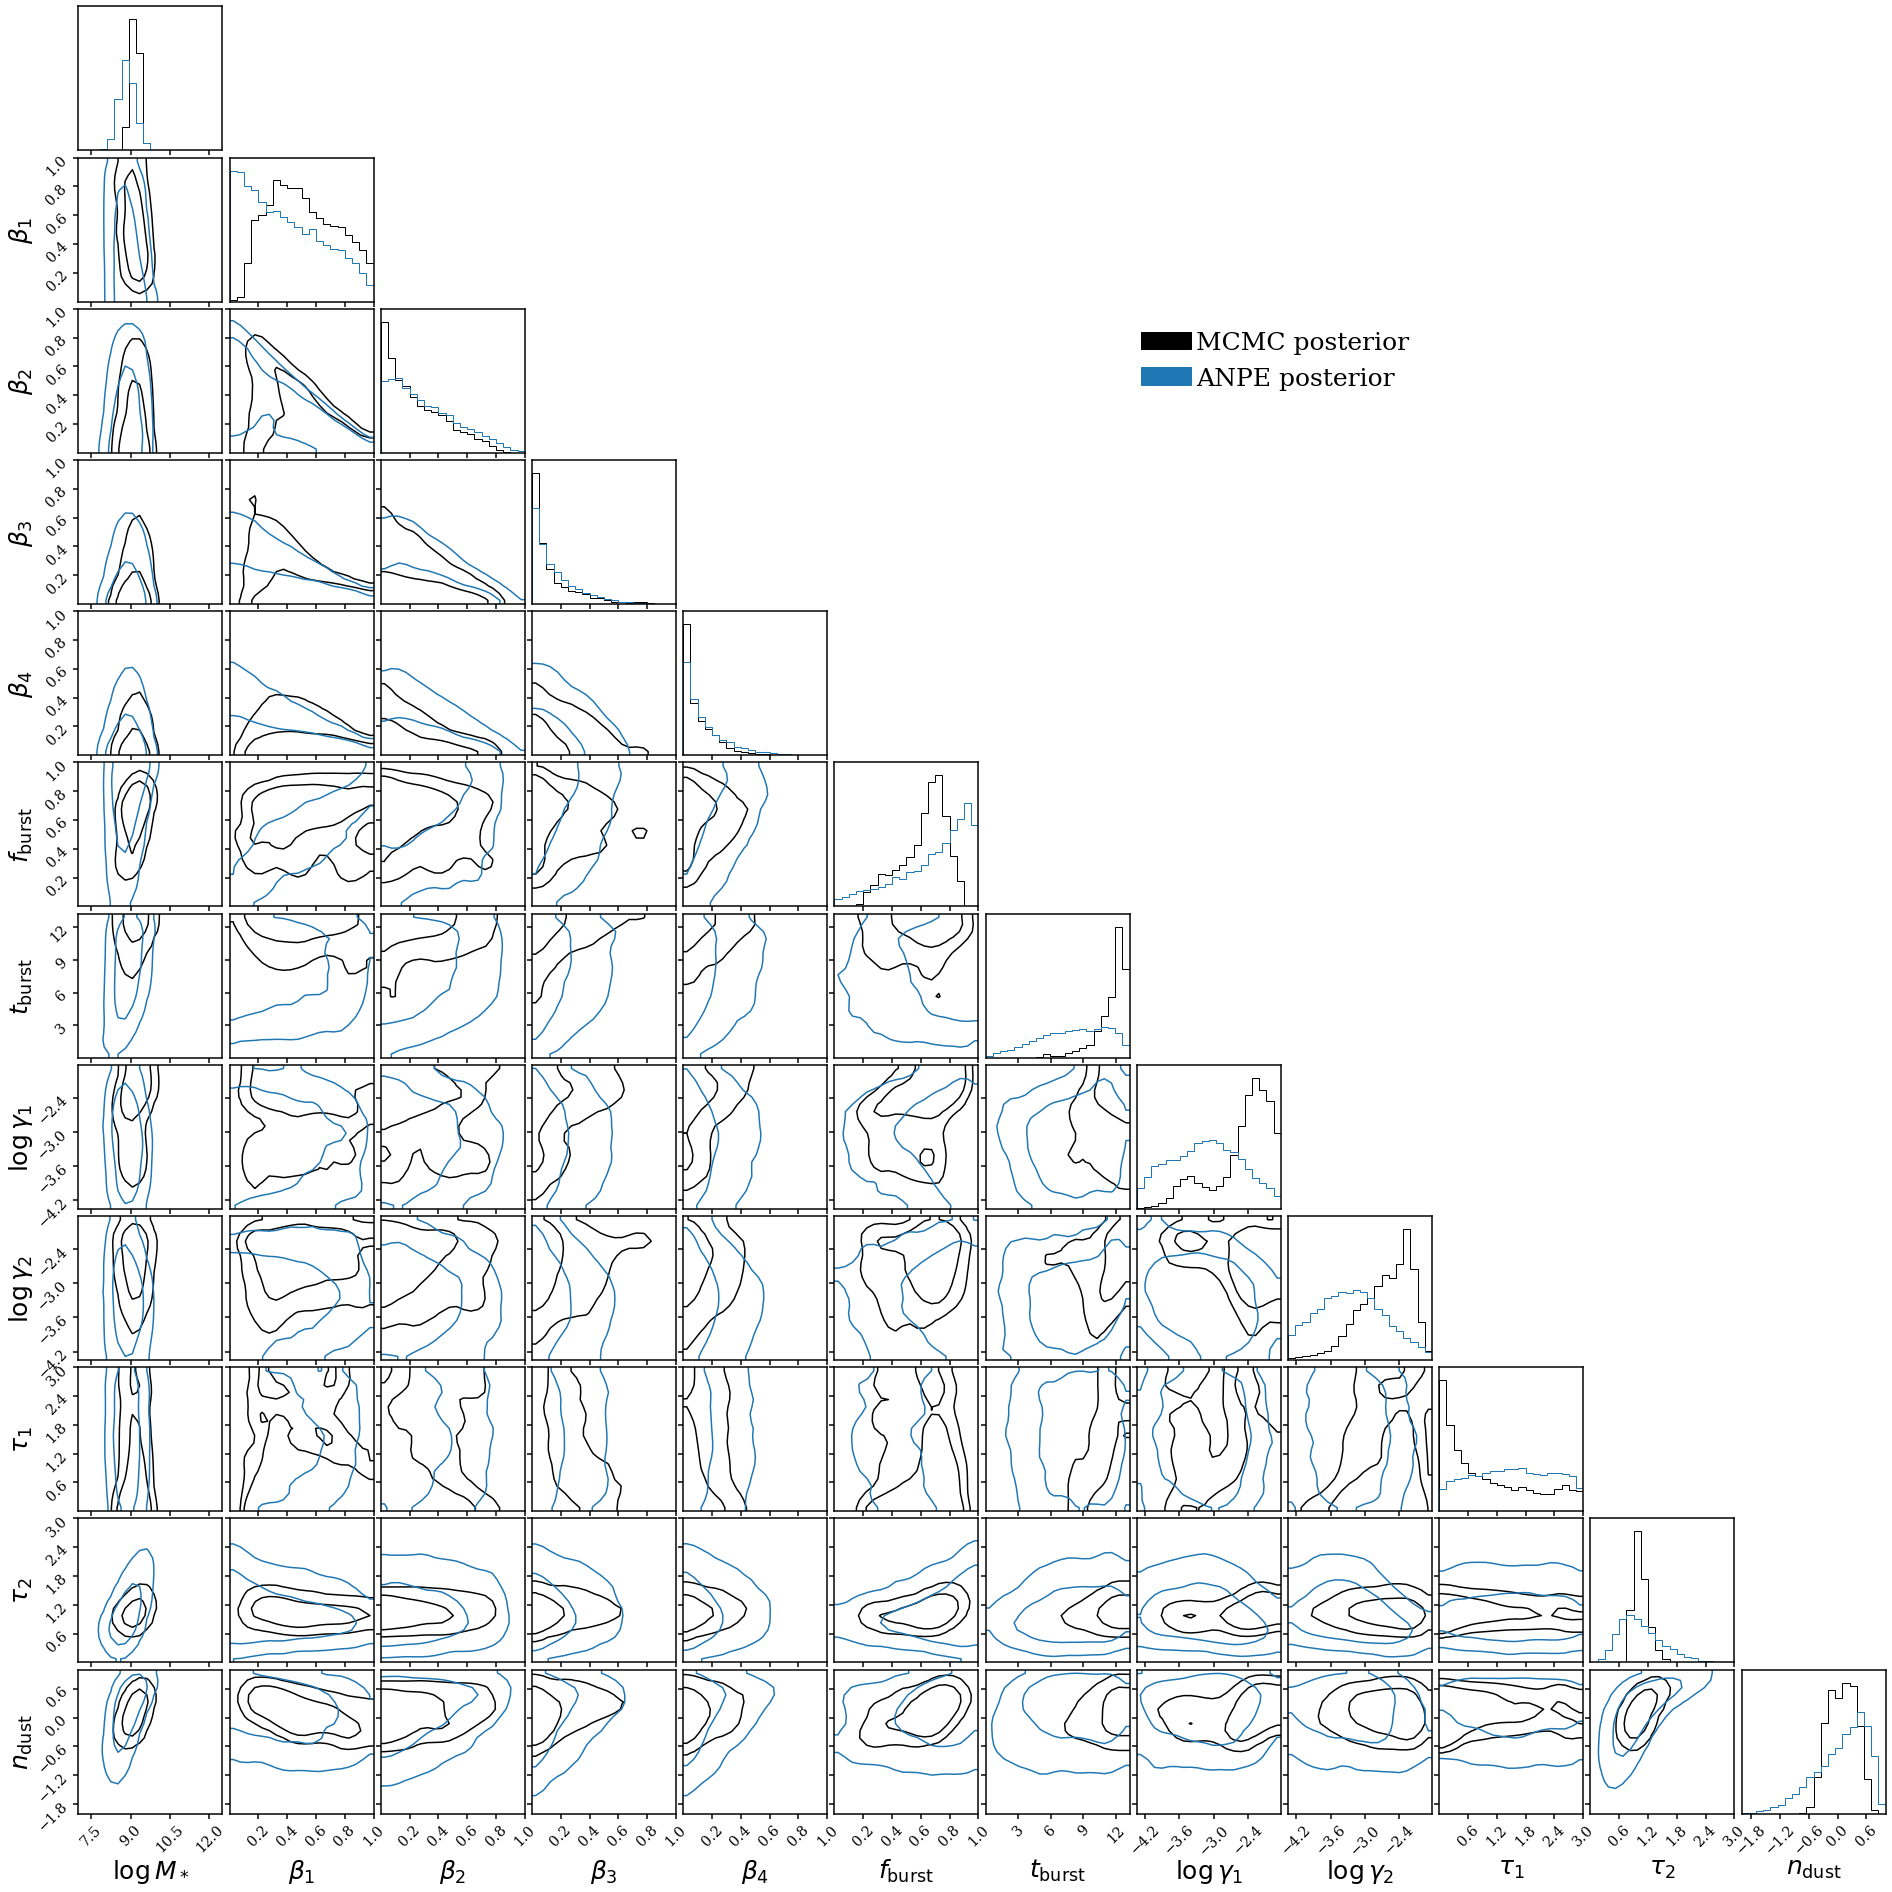

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

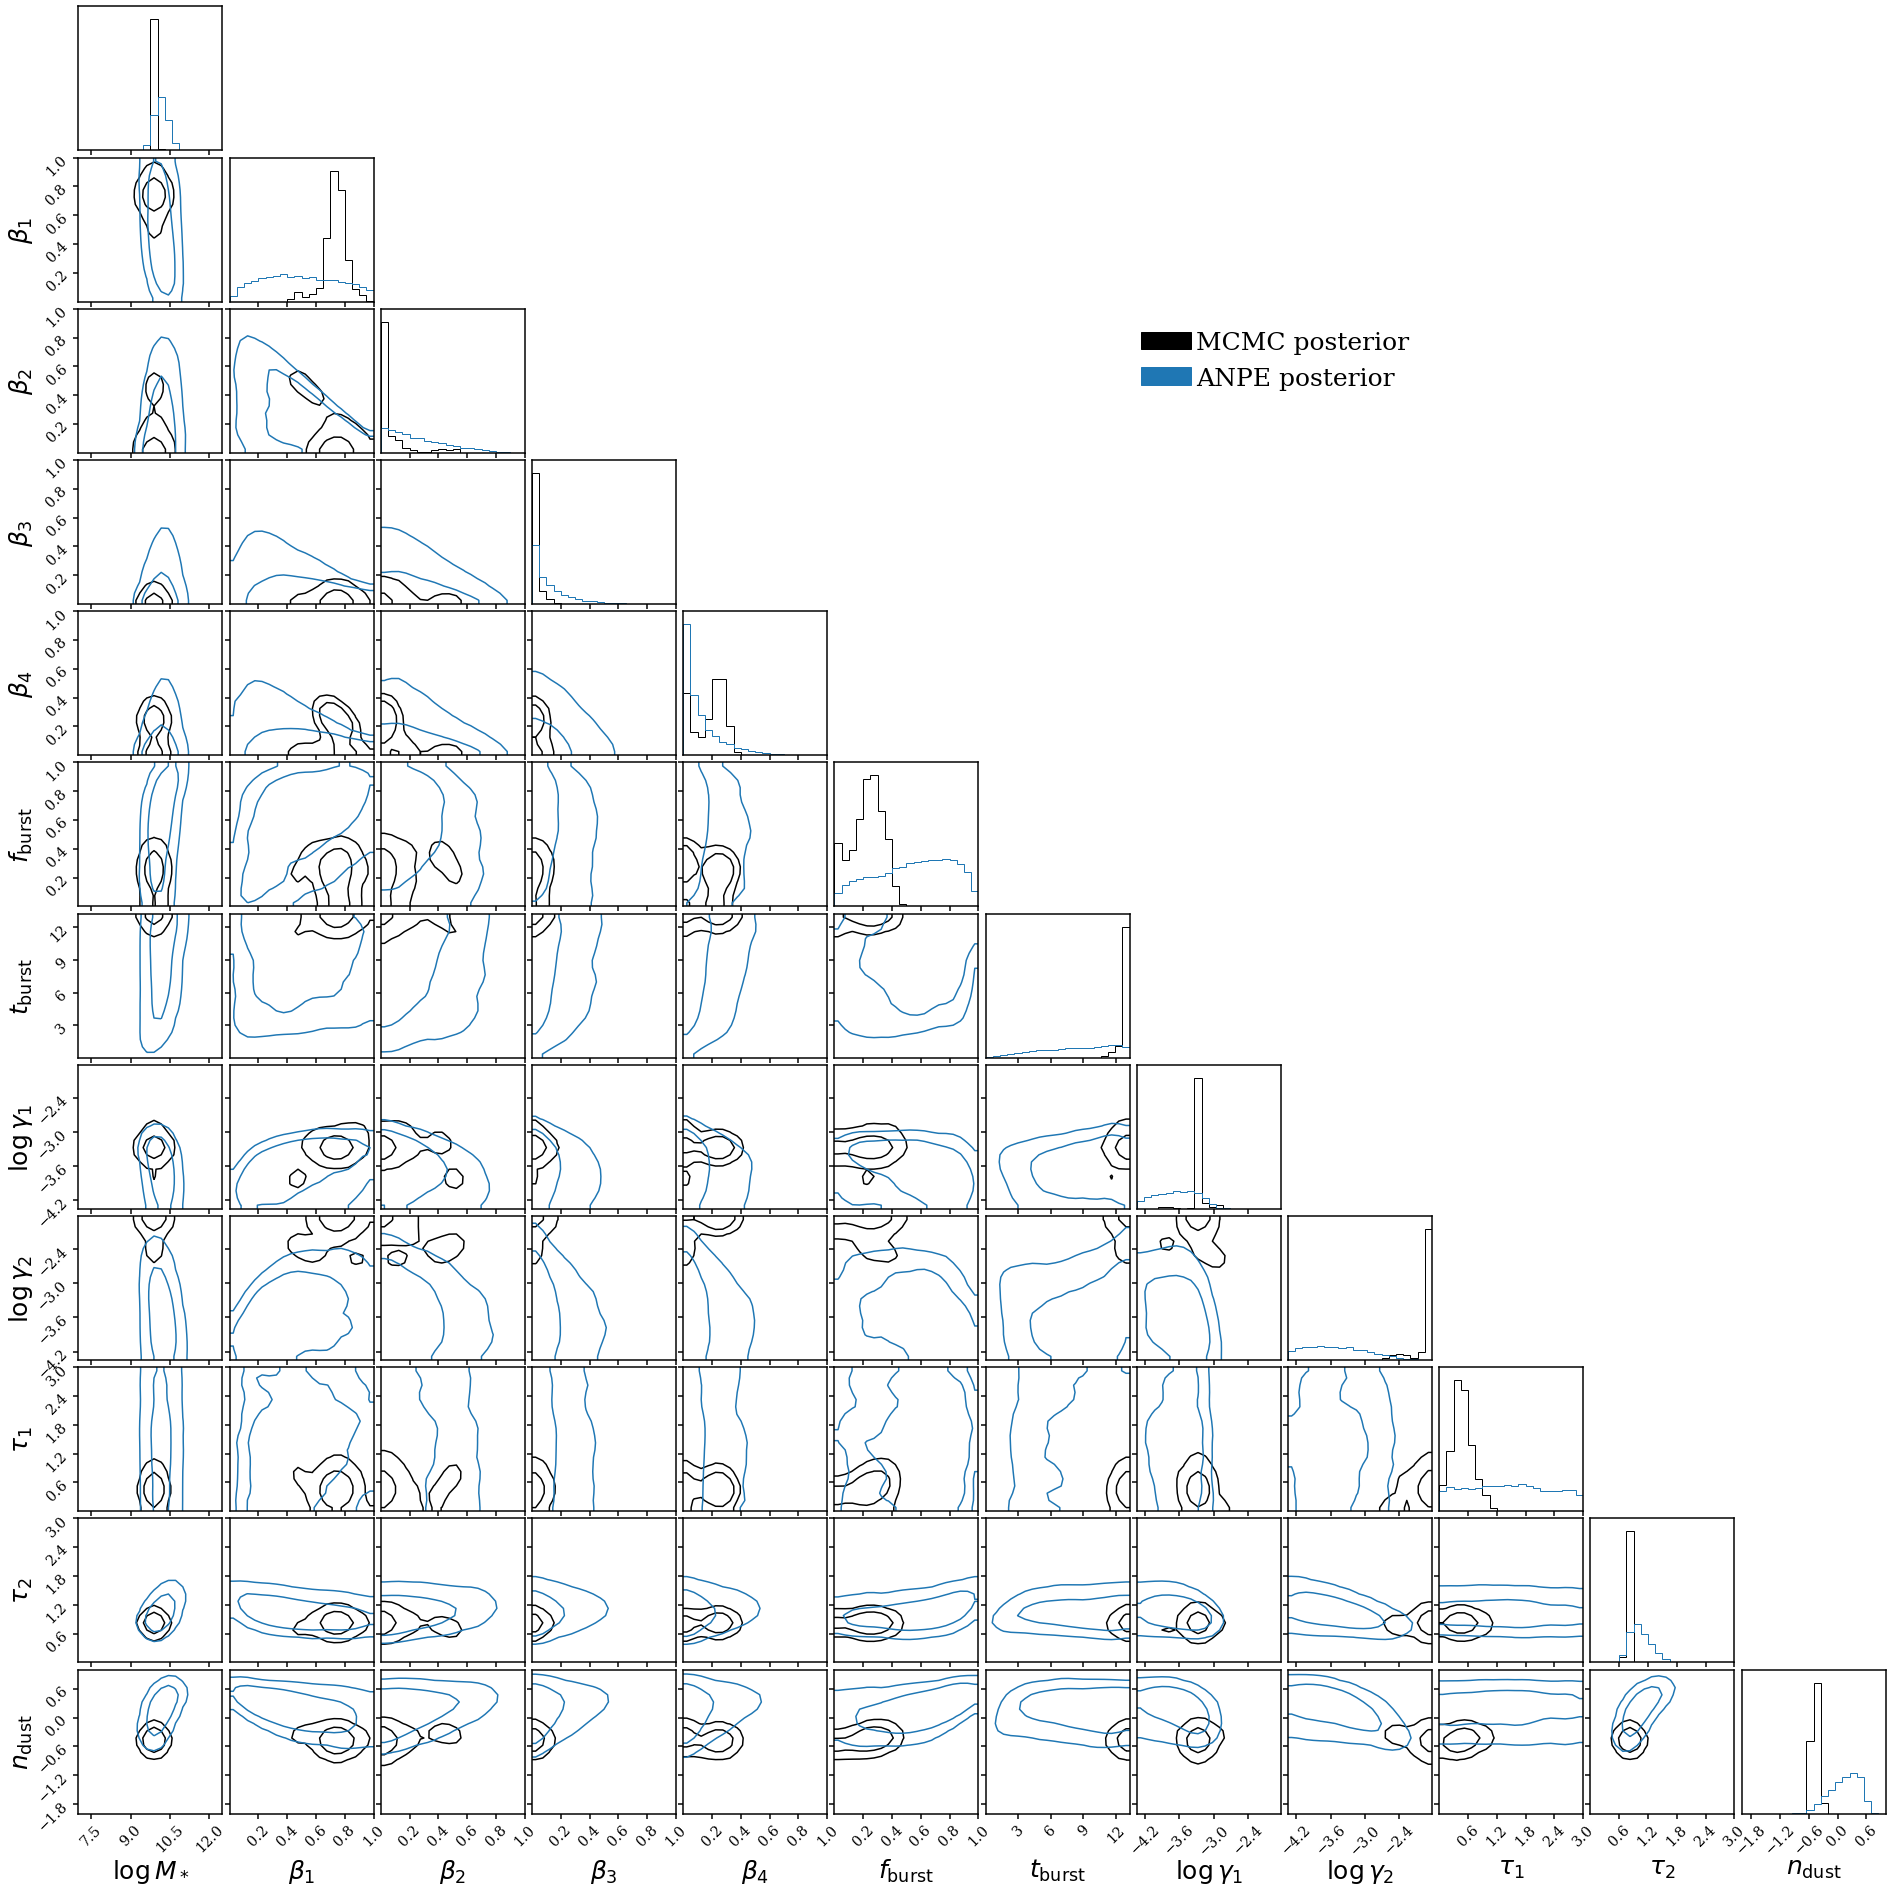

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

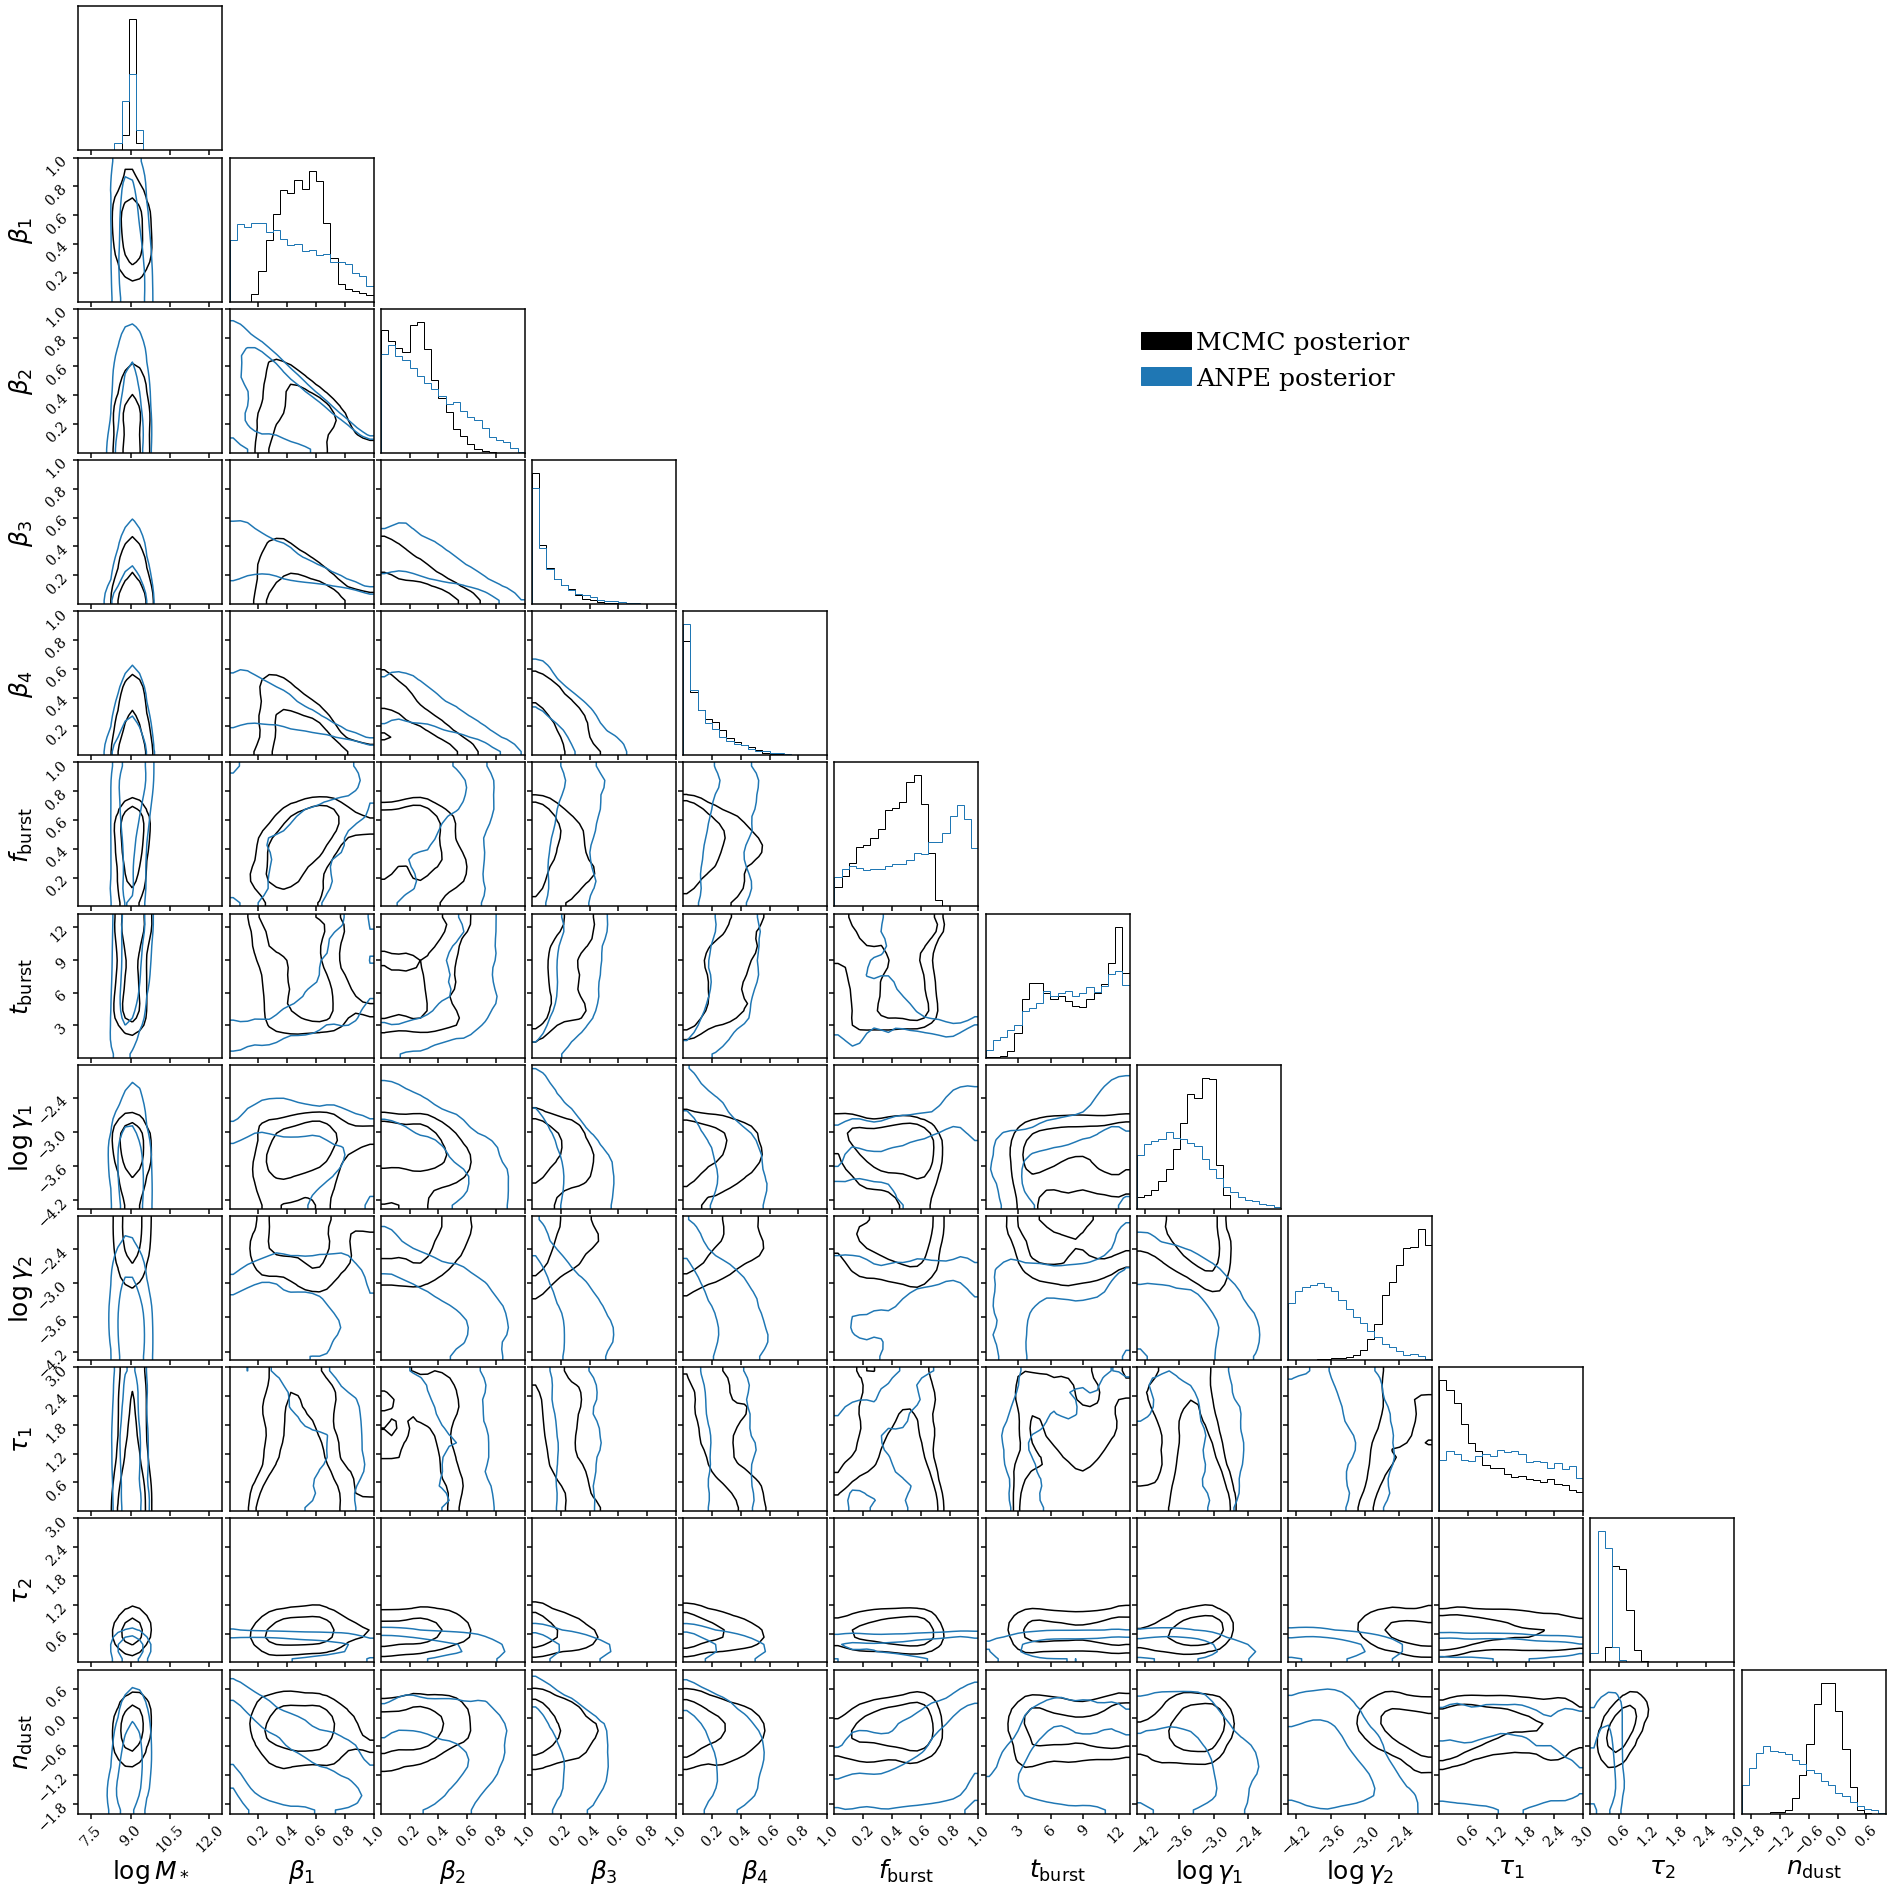

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

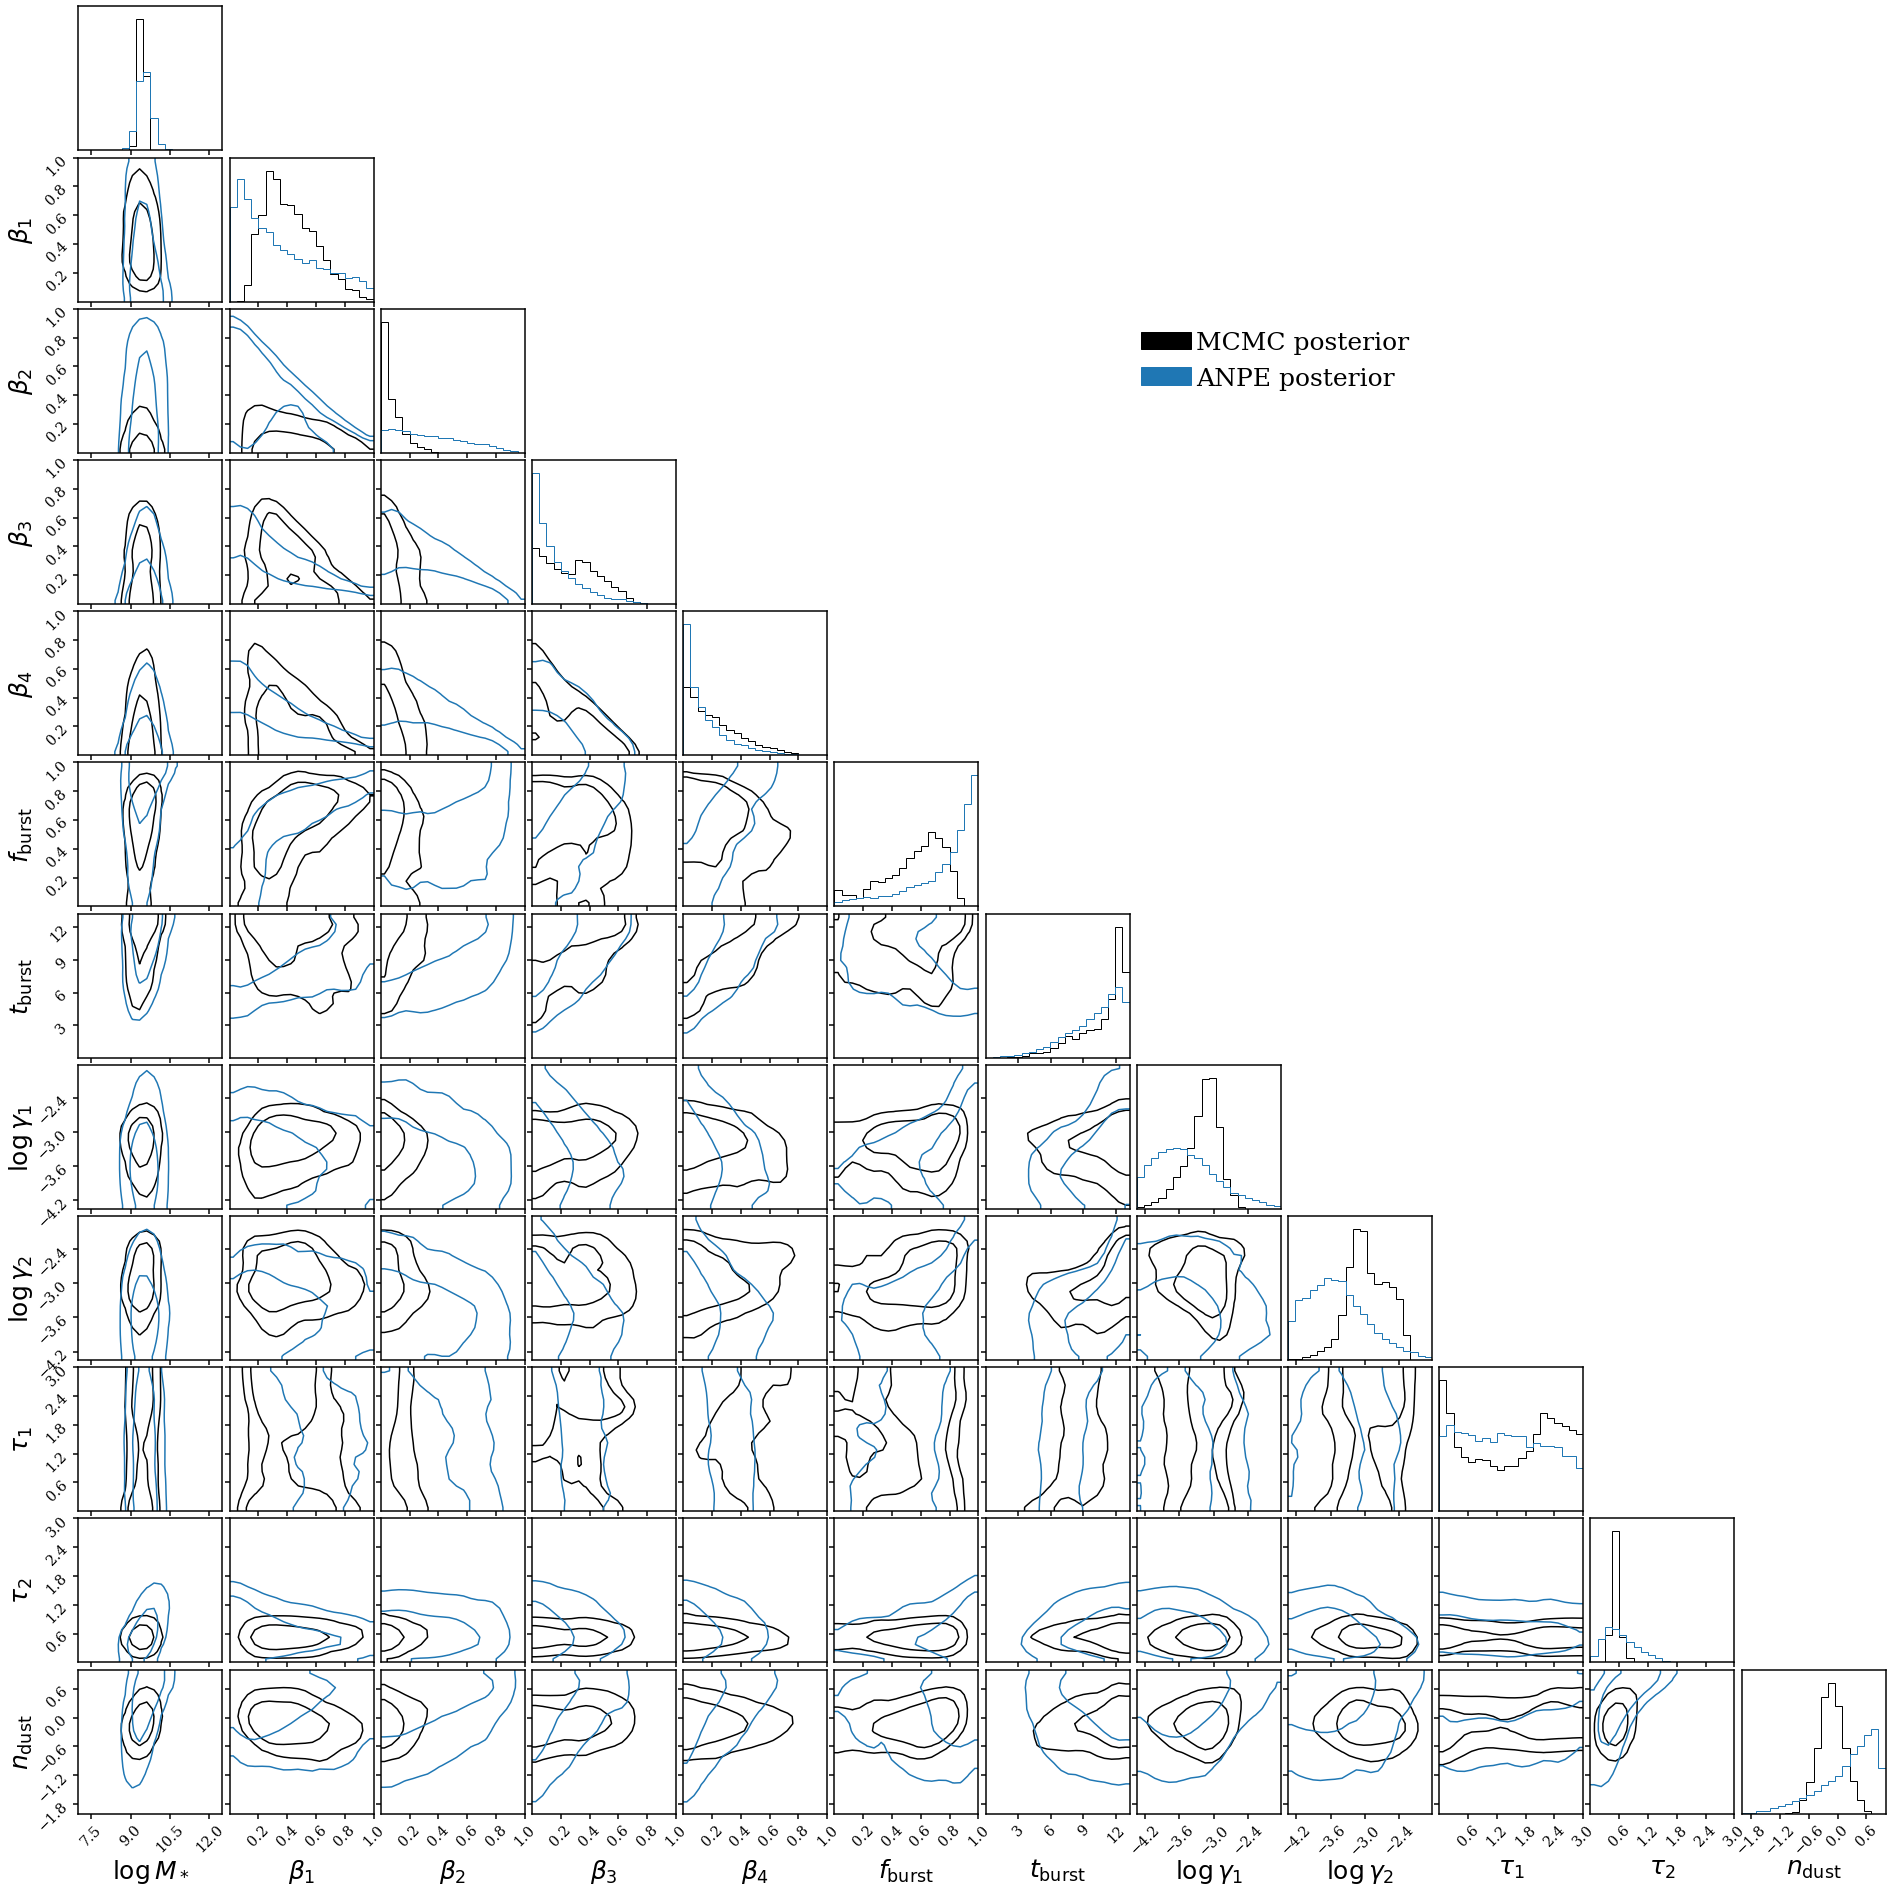

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

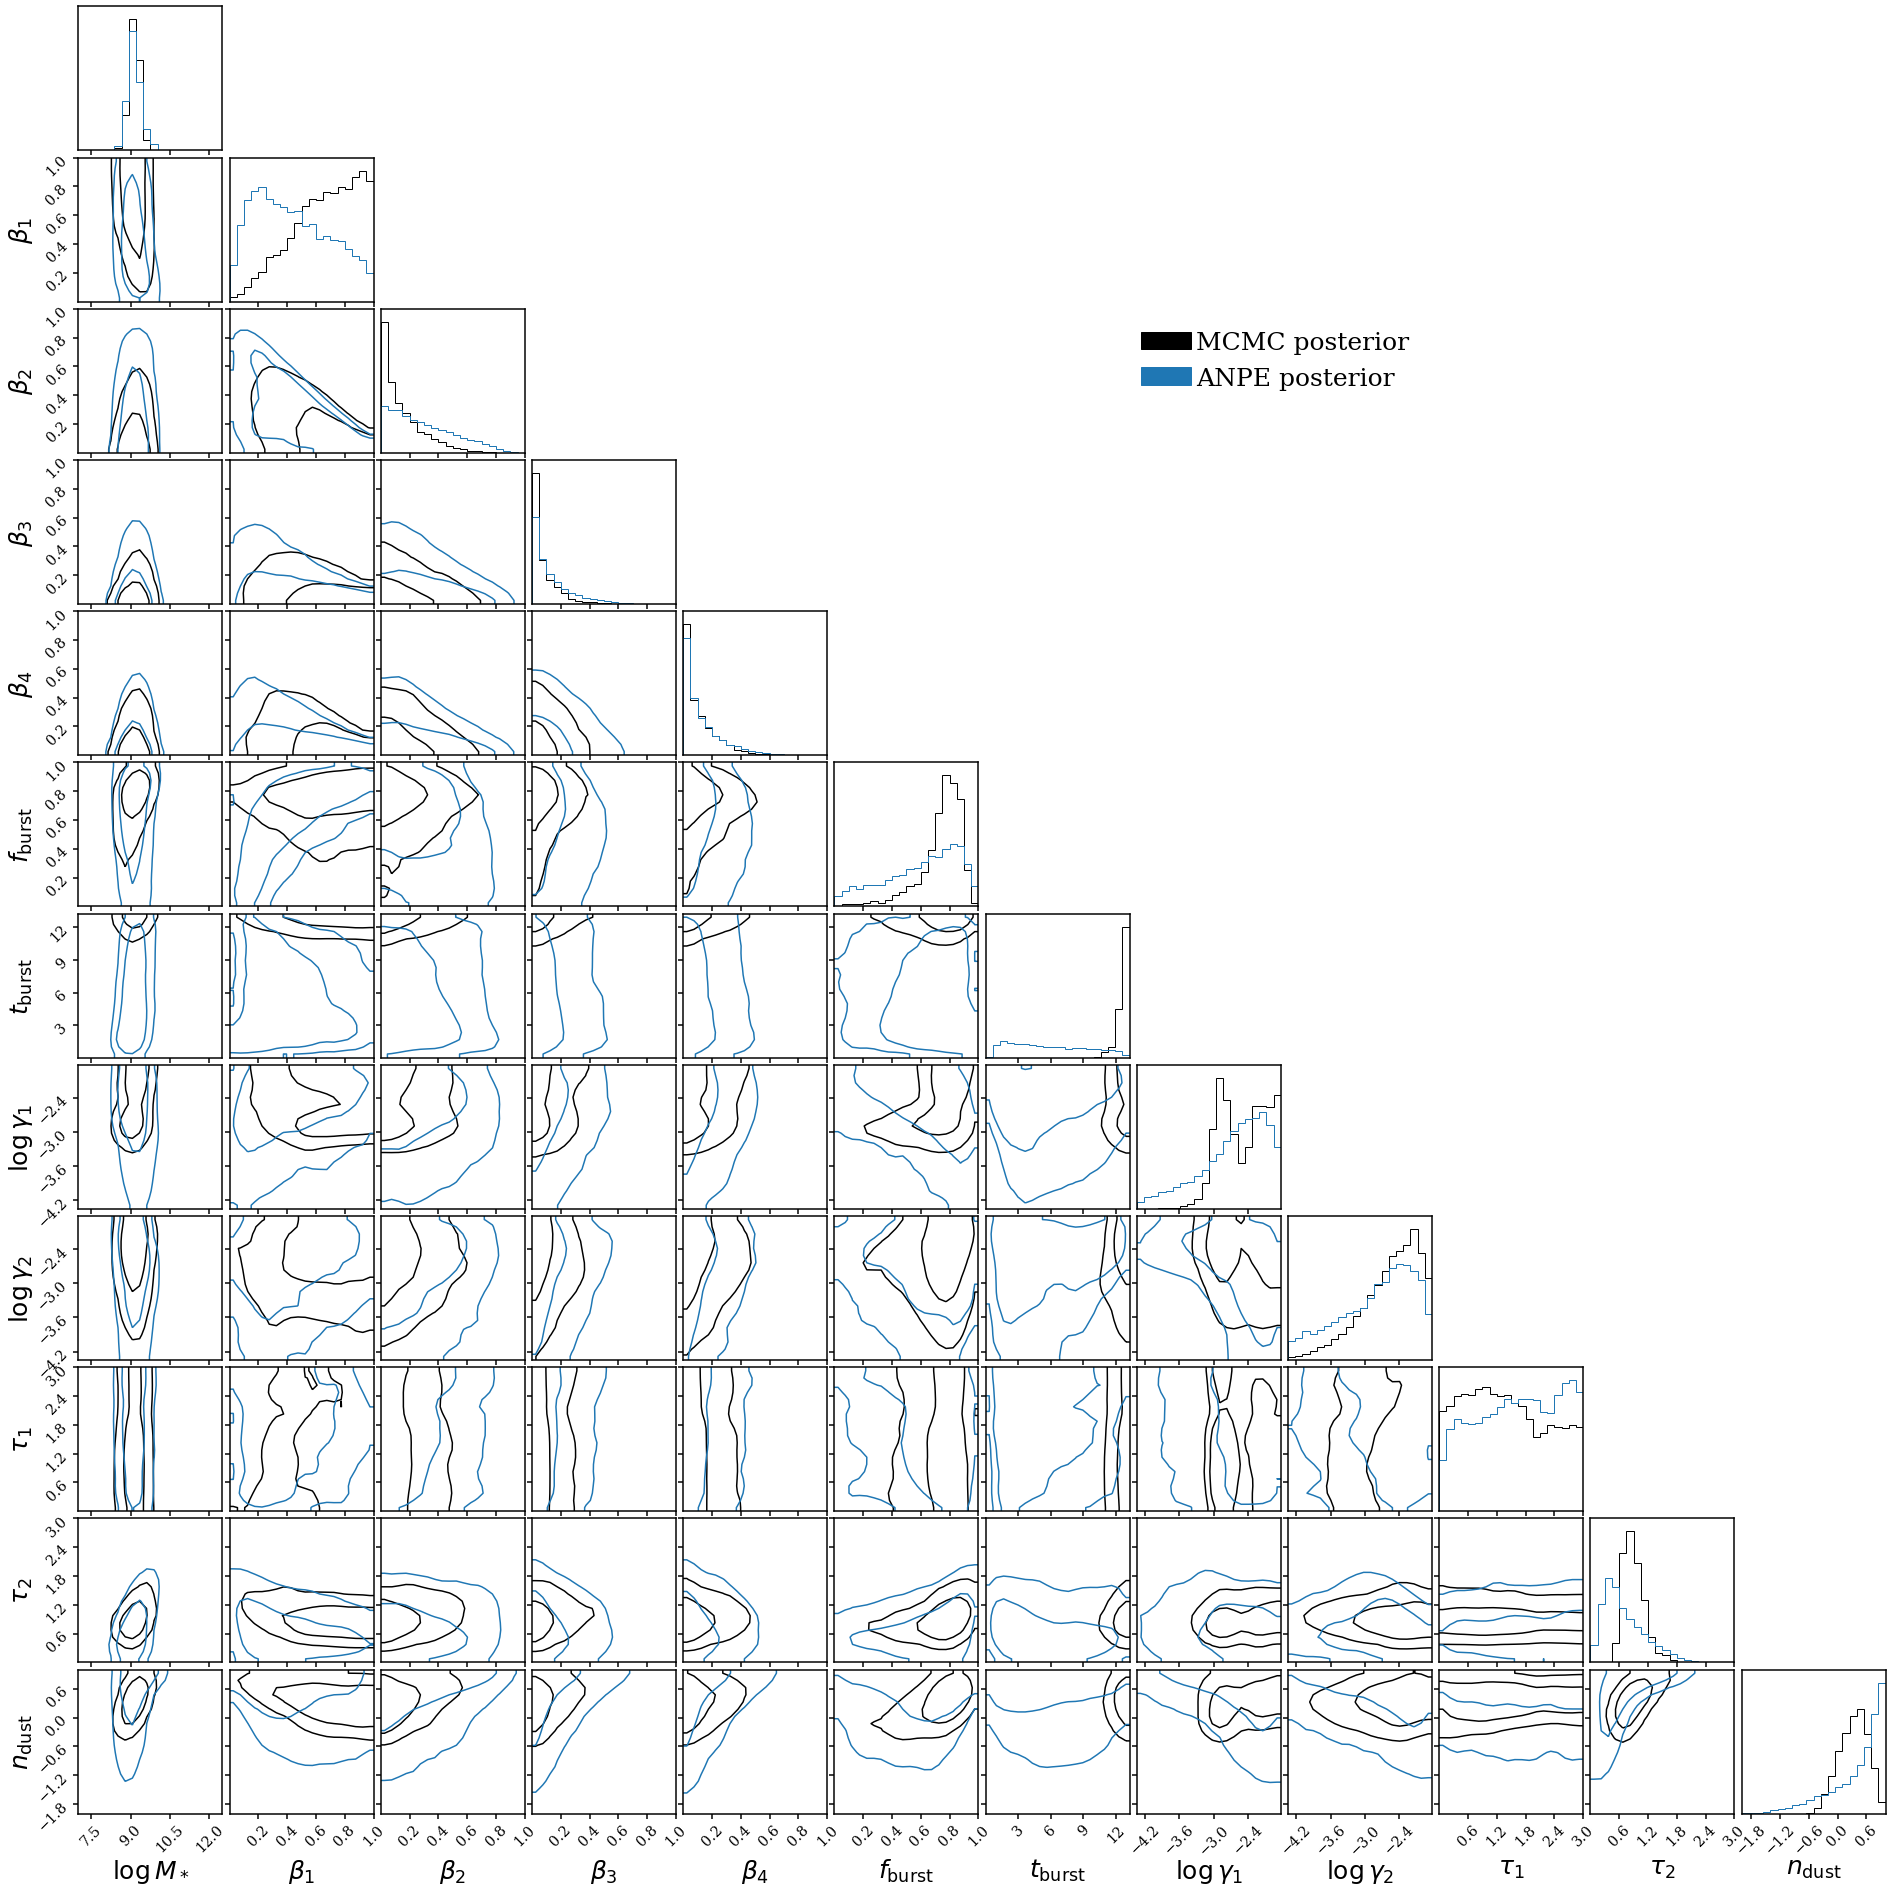

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

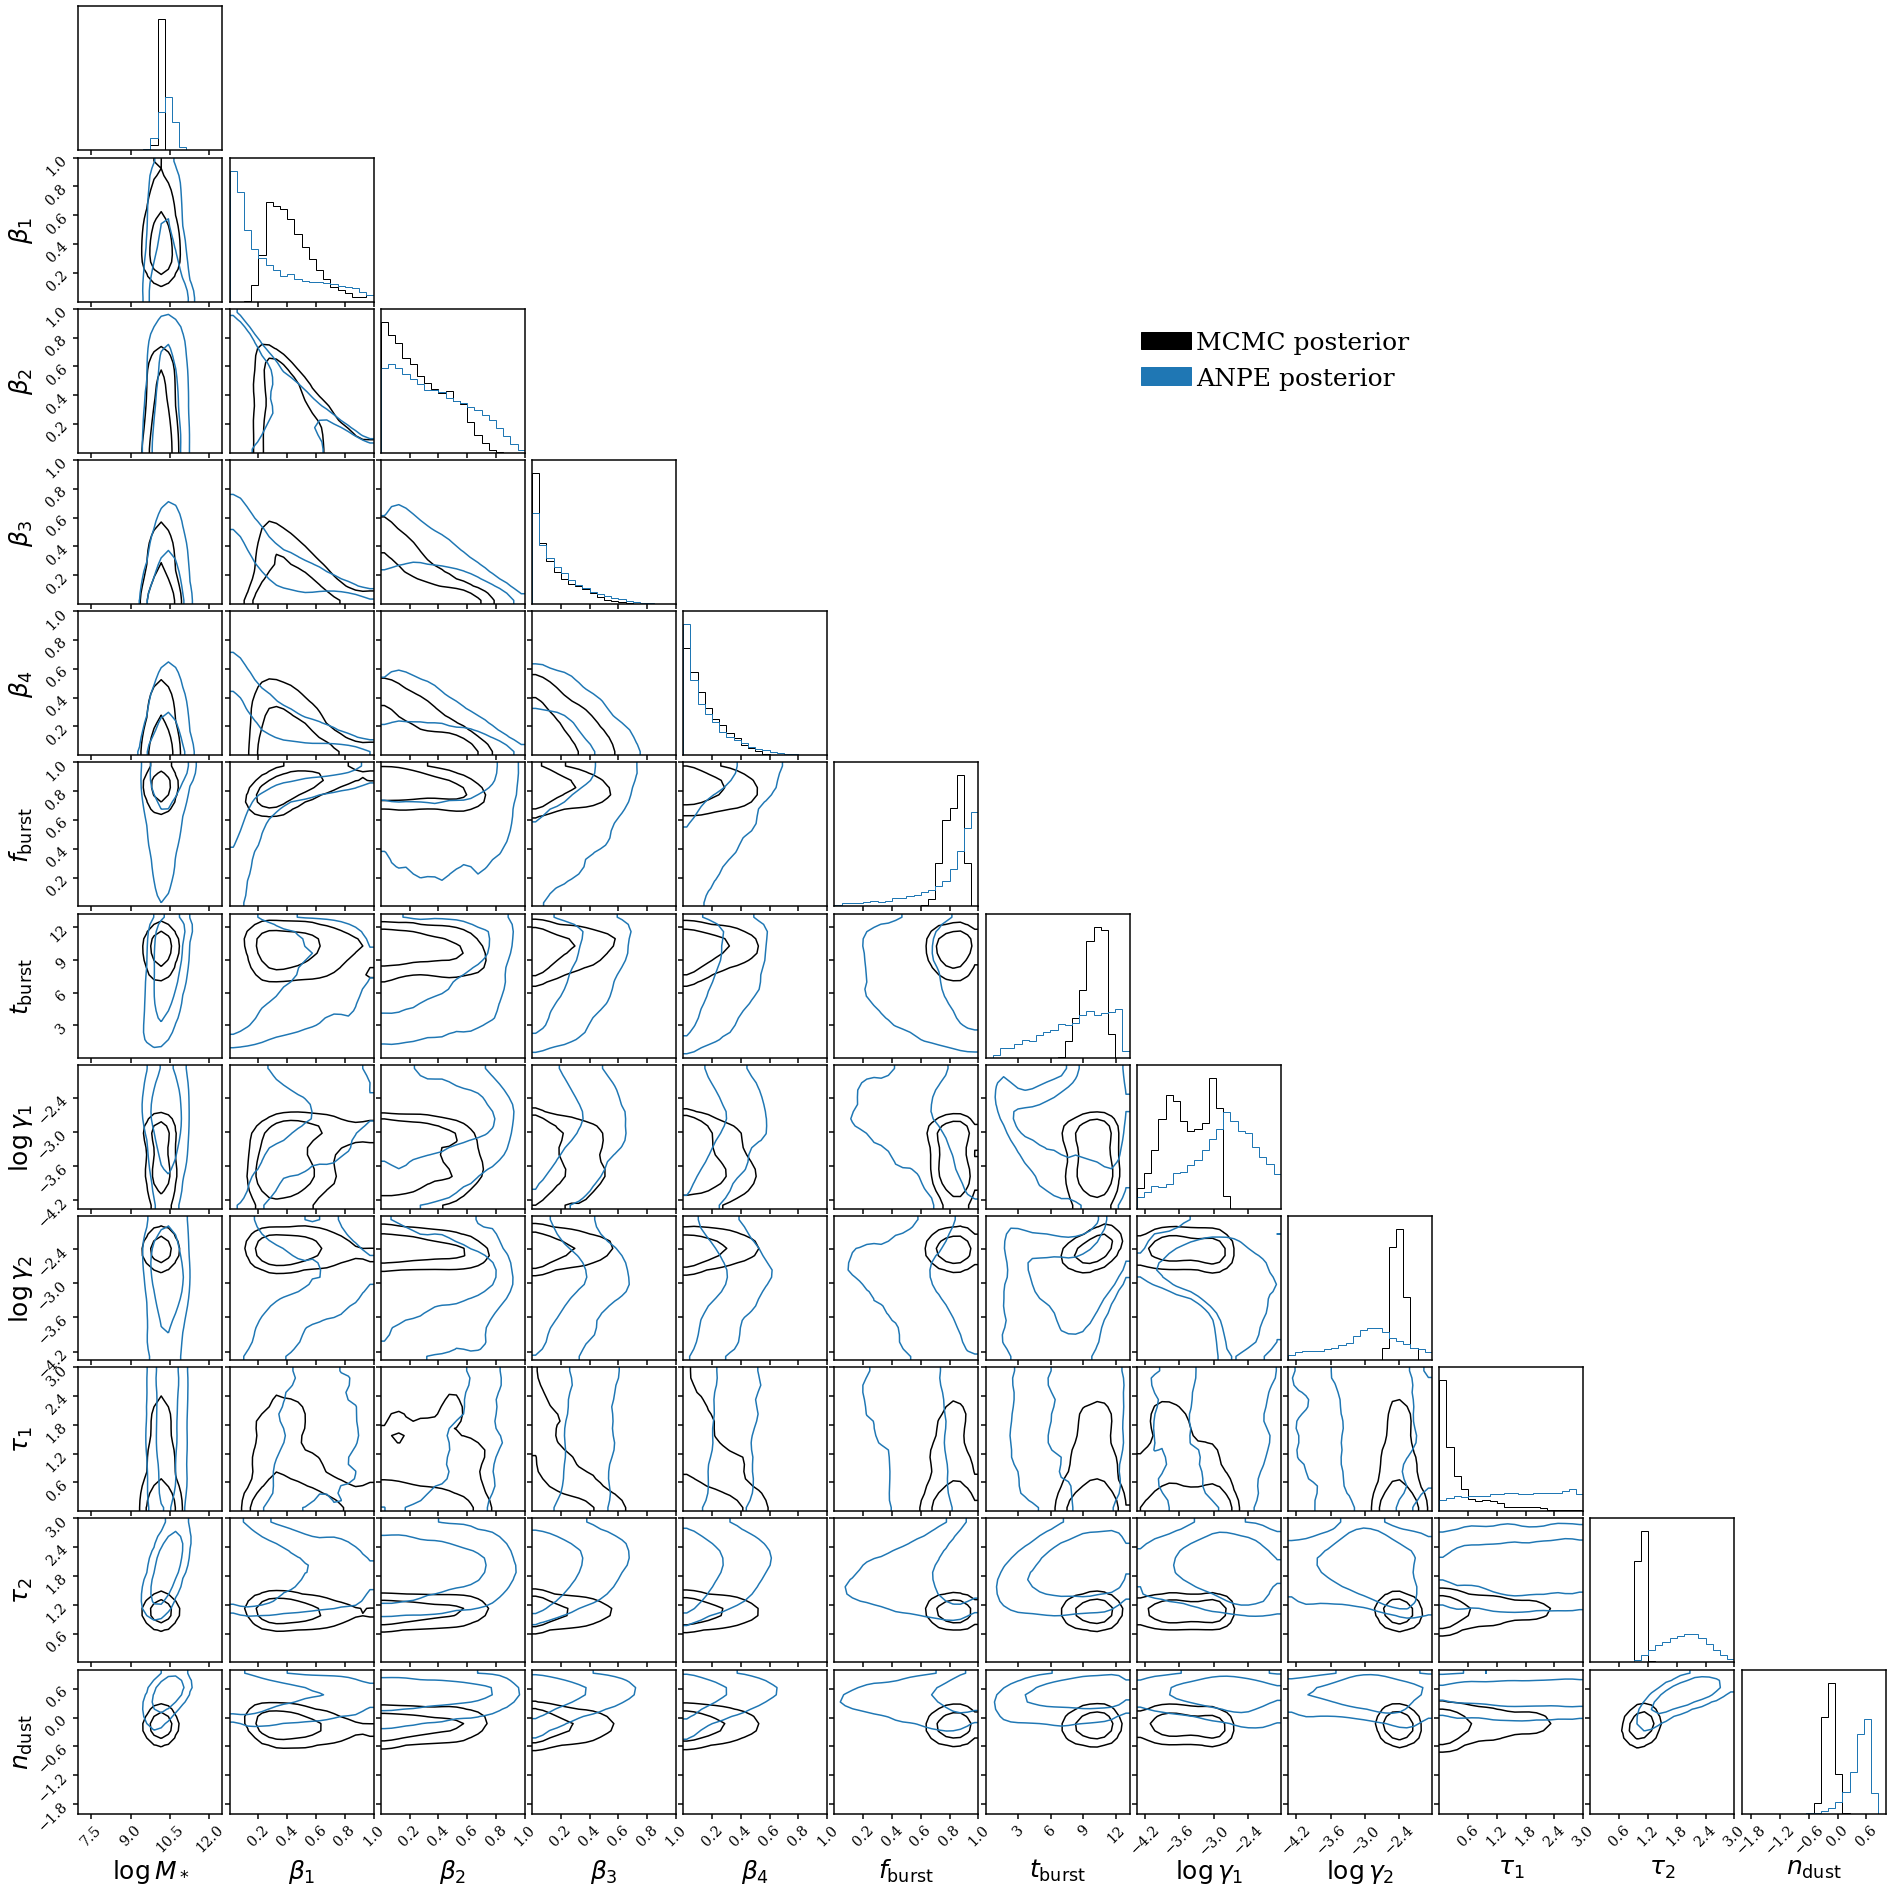

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

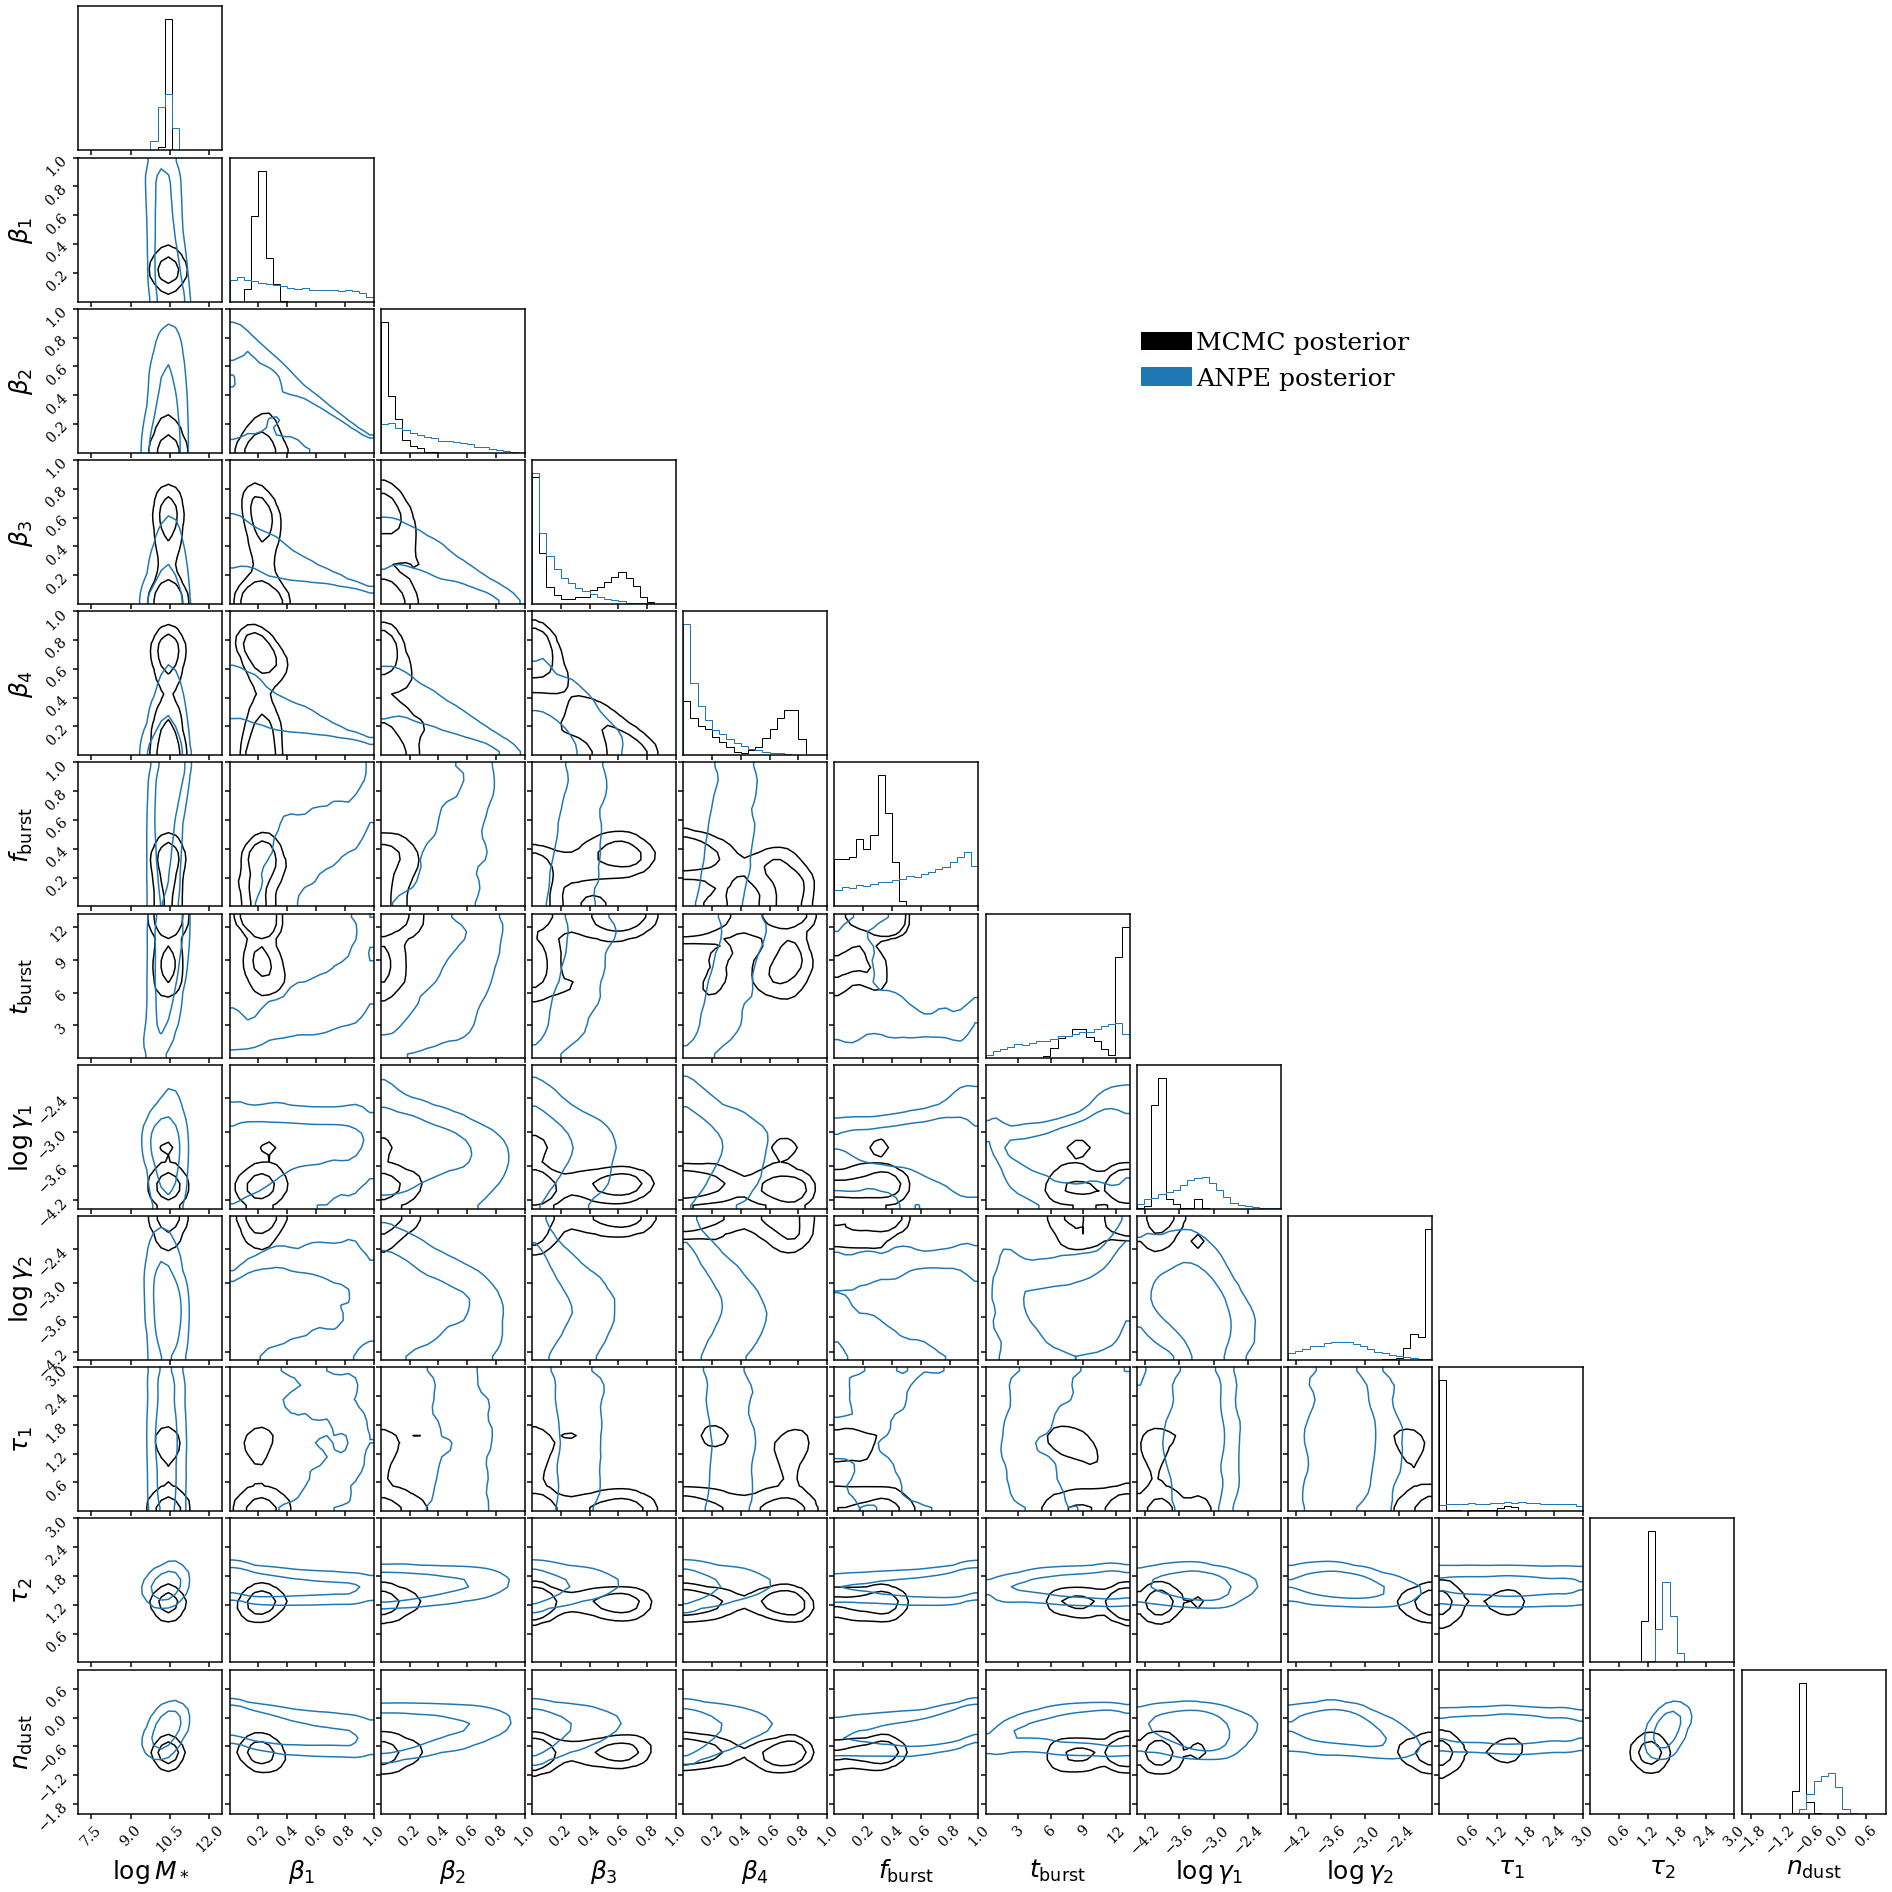

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

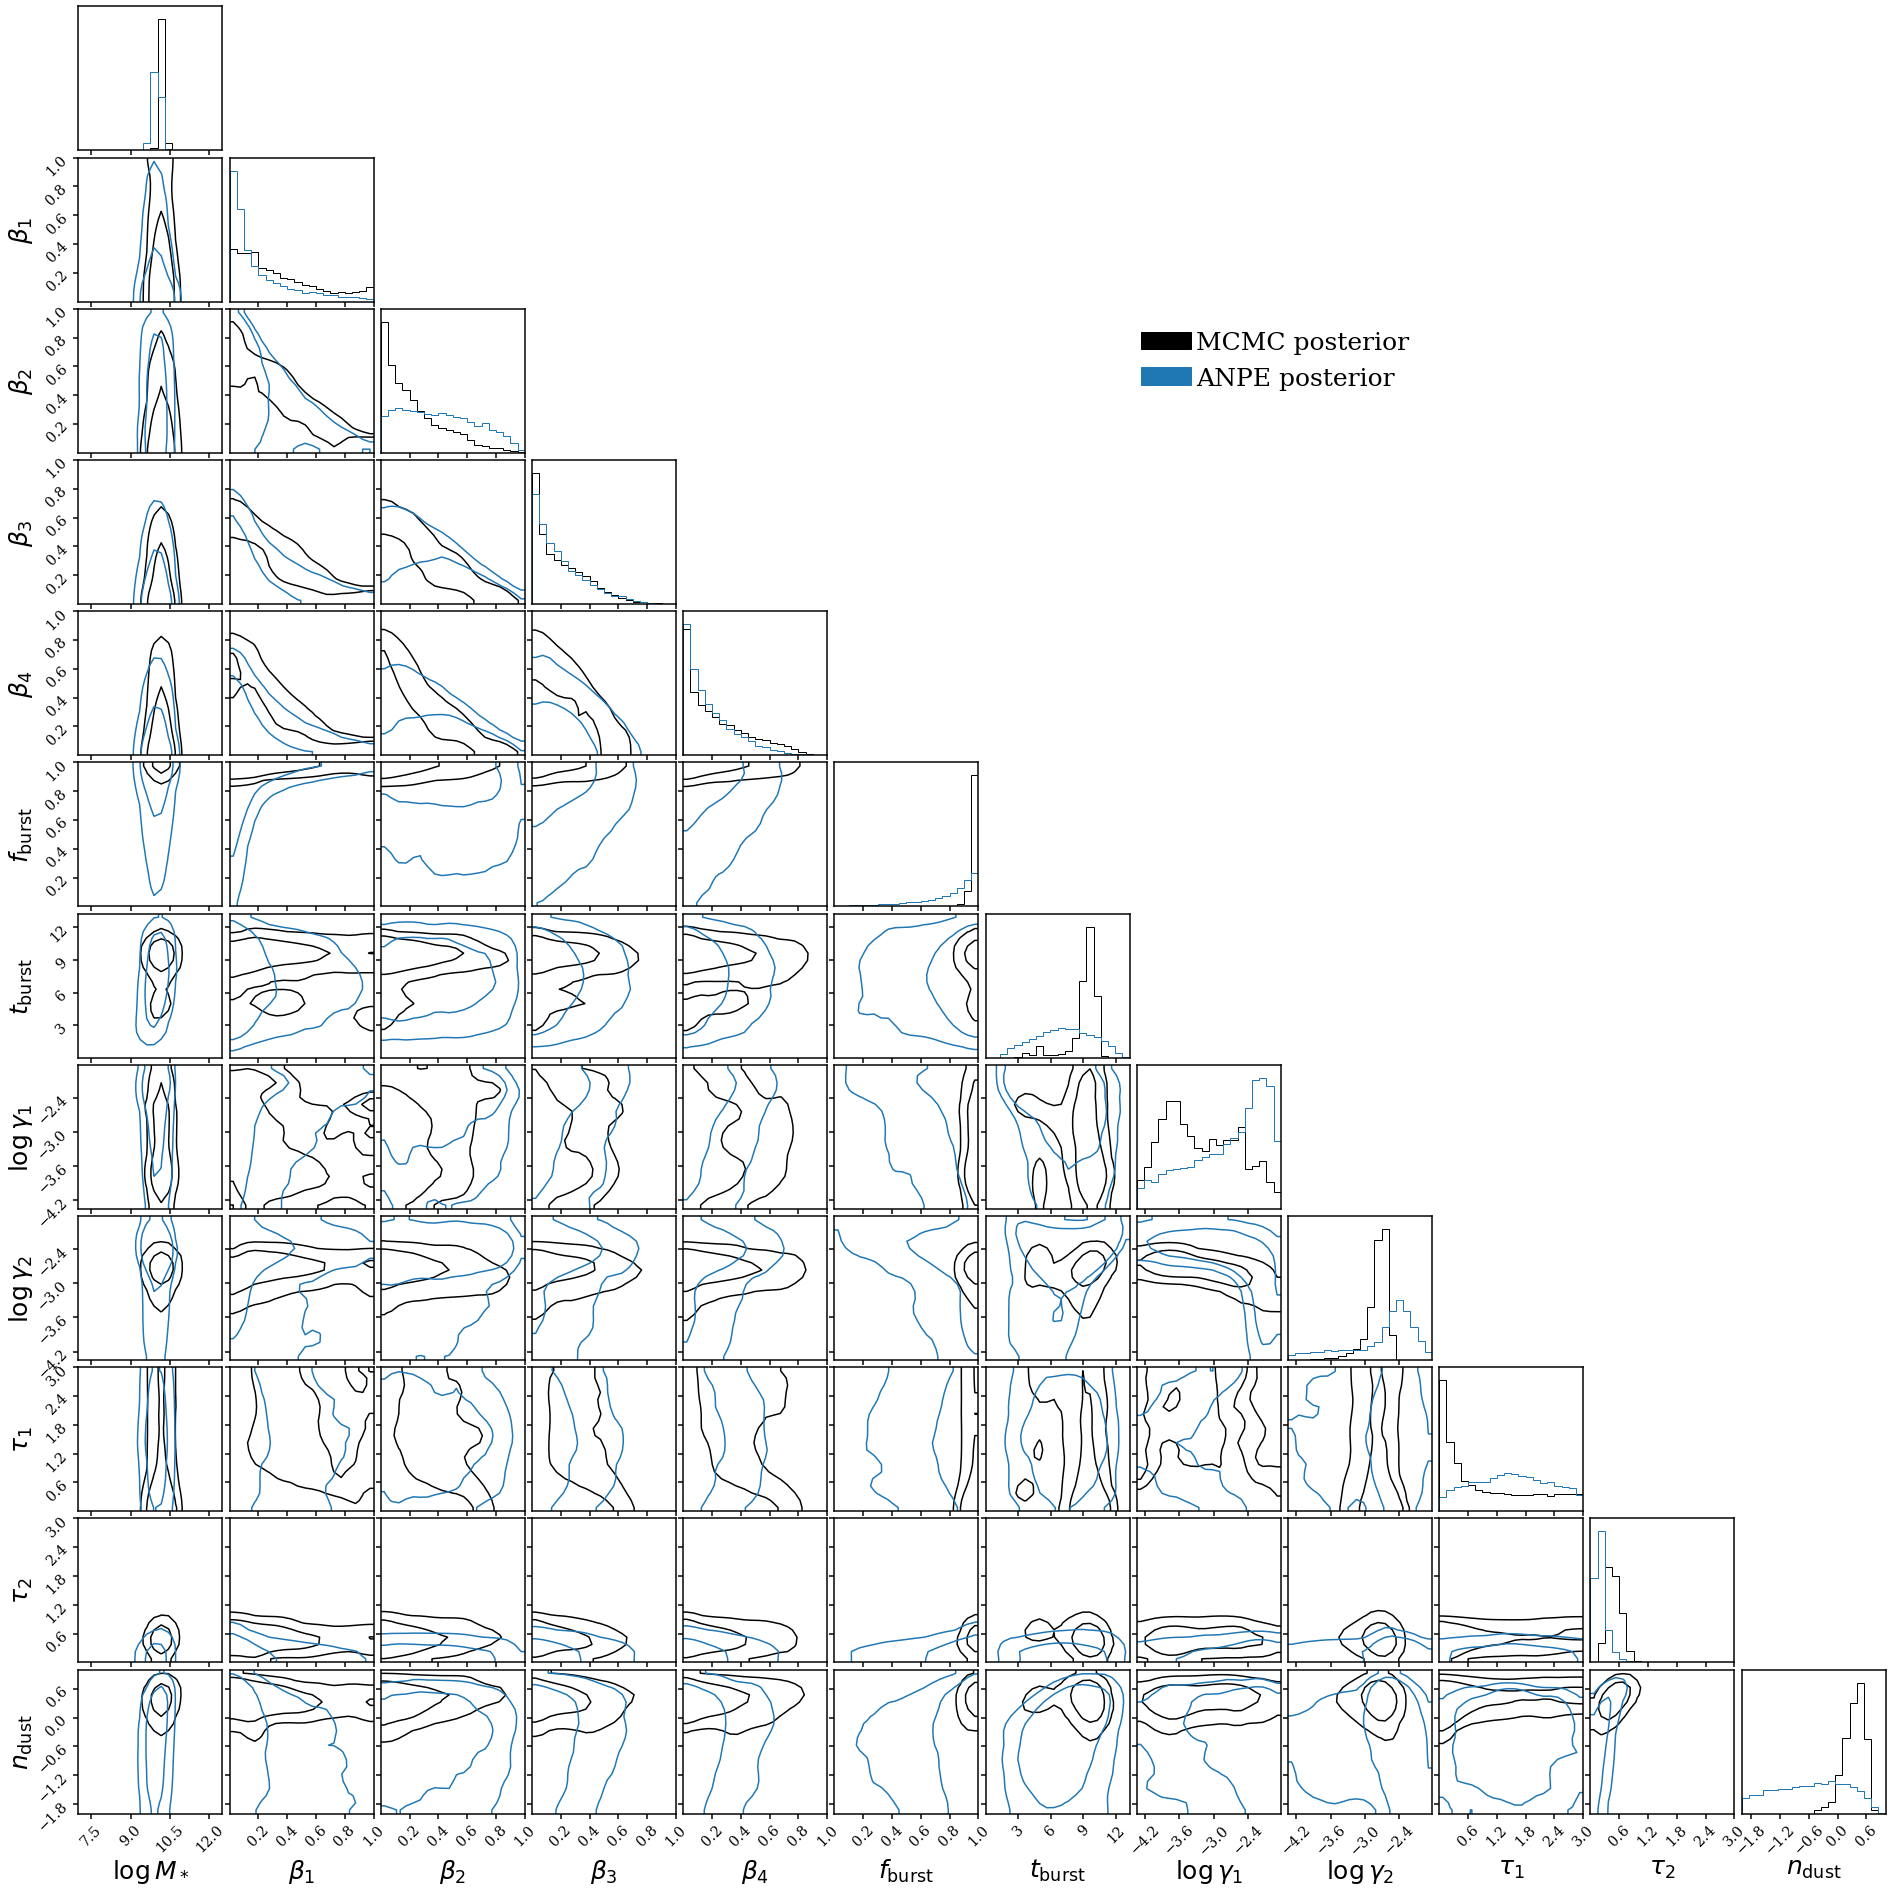

In [17]:
ndim = len(theta_lbls)
nmcmc = 10000
for igal in range(10): 
    # read samples from MCMC
    fmcmc = os.path.join(dat_dir, 'mcmc_spectra', 'mcmc.sdss.test.%i.hdf5' % igal)
    if not os.path.isfile(fmcmc): continue
    mcmc = h5py.File(fmcmc, 'r')
    samples_mcmc = Train.flatten_chain(mcmc['mcmc_chain'][...])#[2000:])
    samples_mcmc[:,7:9] = np.log10(samples_mcmc[:,7:9])
    
    # sample posterior using ANPE
    _samples_anpe = hatp_x_y.sample((nmcmc,), x=torch.as_tensor(sdss_data[igal]), show_progress_bars=True)
    # transform anpe samples
    samples_anpe = prior_sps.transform(_samples_anpe.detach().cpu().numpy())

    fig = DFM.corner(samples_mcmc, color='k', levels=[0.68, 0.95], range=theta_range,
                     smooth=True, plot_density=False, plot_datapoints=False, hist_kwargs={'density': True})
    _ = DFM.corner(samples_anpe, color='C0', levels=[0.68, 0.95], range=theta_range,
                   smooth=True, plot_density=False, plot_datapoints=False, hist_kwargs={'density': True}, 
                   labels=theta_lbls, label_kwargs={'fontsize': 25}, fig=fig)
    
    # ndim = int(np.sqrt(len(fig.axes)))
    axes = np.array(fig.axes).reshape((ndim, ndim))

    ax = axes[2, ndim-4]
    ax.fill_between([], [], [], color='k', label='MCMC posterior')
    ax.fill_between([], [], [], color='C0', label='ANPE posterior')
    ax.legend(handletextpad=0.2, markerscale=10, fontsize=25)
    plt.show()